In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split   # for data splitting
from sklearn.metrics import mean_squared_error, r2_score   # for model evaluation
from sklearn.linear_model import LinearRegression   # for linear regression model
from sklearn.ensemble import RandomForestRegressor   # for random forest model
#from xgboost import XGBRegressor   # for XGBoost model
#from lightgbm import LGBMRegressor   # for LightGBM model
#from catboost import CatBoostRegressor   # for CatBoost model
from sklearn.linear_model import Ridge, Lasso   # for ridge and lasso regression

from sklearn.decomposition import PCA   # for PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler   # scaling for PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA   # for LDA
# Batlett tested t-SNE and UMAP have some installation issues on certain systems
# KMO and Bartlett's test require additional libraries
from factor_analyzer.factor_analyzer import calculate_kmo       # KMO test
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity     # Bartlett's test

from sklearn.manifold import TSNE   # for t-SNE
# Bartlett's UMAP implementation has some installation issues on certain systems
#from umap import UMAP   # for UMAP

# Temporal tests 
from statsmodels.tsa.stattools import adfuller   # for ADF test
from statsmodels.tsa.stattools import kpss   # for KPSS test  # KPSS test requires additional libraries
from statsmodels.tsa.seasonal import seasonal_decompose   # for seasonal decomposition
from statsmodels.tsa.arima.model import ARIMA   # for ARIMA model
from statsmodels.tsa.stattools import acf, pacf   # for ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import coint   # for cointegration test
# from pmdarima import auto_arima   # for auto ARIMA model

# Panel data models can be implemented using libraries like linearmodels
from linearmodels.panel import PanelOLS   # for panel data regression
from linearmodels.iv import IV2SLS   # for instrumental variable regression

#from esda.moran import Moran   # for spatial autocorrelation
#from libpysal.weights import KNN   # for spatial weights
#from doubleml import DoubleMLData, DoubleMLPLR   # for Double ML model

from scipy.spatial import distance_matrix
import geopandas as gpd
#import libpysal as ps
#from esda.moran import Moran
#from esda.moran import Moran_Local
from sklearn.neighbors import NearestNeighbors  # Knee-Elbow method for optimal K
from sklearn.cluster import KMeans     # KMeans clustering
from sklearn.datasets import make_blobs 
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import davies_bouldin_score   # Davies-Bouldin score for optimal K
from sklearn.metrics import calinski_harabasz_score   # Calinski-Harabasz score for optimal K
from sklearn.metrics import adjusted_rand_score   # Adjusted Rand Index for clustering evaluation
from sklearn.metrics import silhouette_score    # Silhouette score for optimal K
from sklearn.cluster import DBSCAN      # DBSCAN clustering

from sklearn.inspection import permutation_importance

In [3]:
# Hyper parameter values
RANDOM_STATE = 42
scaler_1 = StandardScaler()
scaler_2 = MinMaxScaler()
N_SPLITS = 5
target = 'price'
data_path = 'C:/Users/pragy/OneDrive/Desktop/CDC_Submission Project/dataset'    # path to the data folder (Change for you local system)

In [4]:
df_train = pd.read_csv(data_path + '/cleaned_train.csv')
df_test = pd.read_csv(data_path + '/cleaned_test.csv')

In [5]:
print("train columns : ", df_train.columns)
print("test columns : ", df_test.columns)
print("Same size : ", df_train.shape == df_test.shape)
if df_train.shape != df_test.shape:
    print(len(df_train.columns) - len(df_test.columns), " columns are different")
    print(list(set(df_train.columns) - set(df_test.columns)))
print("Train data types : \n", df_train.dtypes)
print("Test data types : \n", df_test.dtypes)
print("Train dataset shape : ", df_train.shape)
print("Test dataset shape : ", df_test.shape)

train columns :  Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'spatial_cluster_8',
       'renovated', 'pca_sqft_1', 'pca_sqft_2', 'pca_sqft_3', 'pca_sqft_4',
       'perks'],
      dtype='object')
test columns :  Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'spatial_cluster_8', 'renovated',
       'pca_sqft_1', 'pca_sqft_2', 'pca_sqft_3', 'pca_sqft_4', 'perks'],
      dtype='object')
Same size :  False
1  columns are different
['price']
Train data types : 
 id                     int64
date                  object
price                  int64
bed

Date needs to be corrected, rest every feature is quite well behaved.

In [5]:
df_train

id        date   price  bedrooms  bathrooms  sqft_living  \
0      7525410190  2014-05-02  550000         3       1.75         2910   
1      5101405331  2014-05-02  495000         4       1.75         1600   
2      2771102144  2014-05-02  385000         3       3.25         1320   
3      4408100095  2014-05-02  308500         2       1.00          850   
4      5056500260  2014-05-02  440000         4       2.25         2160   
...           ...         ...     ...       ...        ...          ...   
16204  8149600265  2015-05-14  725000         4       1.75         1980   
16205  1786200010  2015-05-14  456500         4       2.50         2580   
16206  6752600320  2015-05-14  360000         4       2.50         2020   
16207  7923600250  2015-05-15  450000         5       2.00         1870   
16208  5101400871  2015-05-24  445500         2       1.75         1390   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
0         35200     1.5           0     0  ...      8        2910   
1          6380     1.0           0     0  ...      8        1130   
2          1327     2.0           0     0  ...      8        1040   
3          6174     1.0           0     0  ...      7         850   
4          8119     1.0           0     0  ...      8        1080   
...         ...     ...         ...   ...  ...    ...         ...   
16204      5850     1.0           0     1  ...      8        1380   
16205     11780     2.0           0     0  ...      9        2580   
16206      7289     2.0           0     0  ...      7        2020   
16207      7344     1.5           0     0  ...      7        1870   
16208      6670     1.0           0     0  ...      6         720   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0                  0      1979             0    98075  47.5747 -122.035   
1                470      1959             0    98125  47.7010 -122.306   
2                280      2008             0    98199  47.6506 -122.383   
3                  0      1950             0    98155  47.7352 -122.328   
4               1080      1966             0    98006  47.5443 -122.177   
...              ...       ...           ...      ...      ...      ...   
16204            600      1960             0    98116  47.5607 -122.391   
16205              0      2003             0    98038  47.3658 -122.040   
16206              0      1994             0    98031  47.4010 -122.171   
16207              0      1960             0    98007  47.5951 -122.144   
16208            670      1941             0    98115  47.6914 -122.308   

       sqft_living15  sqft_lot15  
0               2590       37500  
1               1090        6380  
2               1440        1263  
3               1100        6174  
4               1850        9000  
...              ...         ...  
16204           1810        5850  
16205           2410        8403  
16206           2090        7259  
16207           1870        7650  
16208            920        6380  

[16209 rows x 21 columns]

In [6]:
df_train.nunique()

id               16110
date               366
price             3428
bedrooms            12
bathrooms           29
sqft_living        881
sqft_lot          8048
floors               6
waterfront           2
view                 5
condition            5
grade               12
sqft_above         803
sqft_basement      280
yr_built           116
yr_renovated        69
zipcode             70
lat               4775
long               708
sqft_living15      692
sqft_lot15        7279
dtype: int64

Hence there are a few categorical values, which will require One-Hot Encoding.

In [7]:
# Number of 0 Values in each column
zero_counts = (df_train == 0).sum()
zero_counts

id                   0
date                 0
price                0
bedrooms             8
bathrooms            7
sqft_living          0
sqft_lot             0
floors               0
waterfront       16096
view             14604
condition            0
grade                0
sqft_above           0
sqft_basement     9882
yr_built             0
yr_renovated     15537
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
dtype: int64

While only a few features have a very strong bias and skewness, every other variable is well behaved with no major missing value or 0 values.

In [6]:
# number of observations per date
# Definitely a Panel Data Structure
obs_per_date_train = df_train['date'].value_counts().sort_index()
obs_per_date_test = df_test['date'].value_counts().sort_index()

In [7]:
target = 'price'
features_num = list(set(df_train.columns) - set(['price', 'date', 'id', 'lat', 'long']))
categorical_features = [col for col in df_train.columns if df_train[col].nunique() <= 12 and col != target]
obs_bias_features = [col for col in df_train.columns if (df_train[col] == 0).sum() > 1000 and col != target]   # bias causing variables (too many 0s)

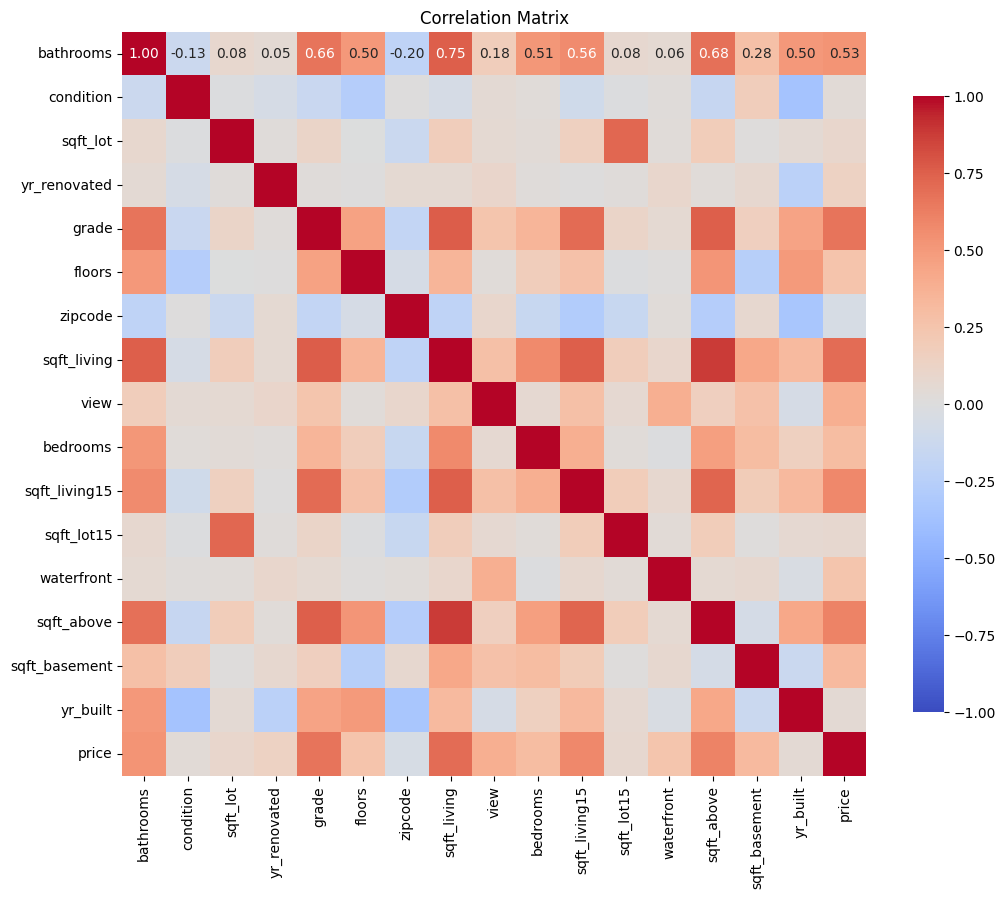

In [10]:
# corr plot with values displayed
corr_plot_features = list(set(df_train.columns) - set(['date', 'id', 'lat', 'long']))

plt.figure(figsize=(12,10))
corr_matrix = df_train[corr_plot_features].corr()   
#sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
#sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, vmax=1.0, vmin=-1.0, center=0)
plt.title('Correlation Matrix')
plt.show()  

There seems to be no Major Multi Collinearity among the features. Hence the need to make extra features based on multi-collinearity vanishes.

In [ ]:
# PCA Analysis for Factor Reduction and studying Dependencies

# first checking for optimal number of components using KMO and Bartlett's test
kmo_all, kmo_model = calculate_kmo(df_train[features_num])
print("KMO Model Value: ", kmo_model)

bartlett_chi2, bartlett_p_value = calculate_bartlett_sphericity(df_train[features_num])
print("Bartlett's Test Chi-square: ", bartlett_chi2)

print("Bartlett's Test p-value: ", bartlett_p_value)

KMO Model Value:  0.7495644308459773
Bartlett's Test Chi-square:  666661.042887864
Bartlett's Test p-value:  0.0


c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


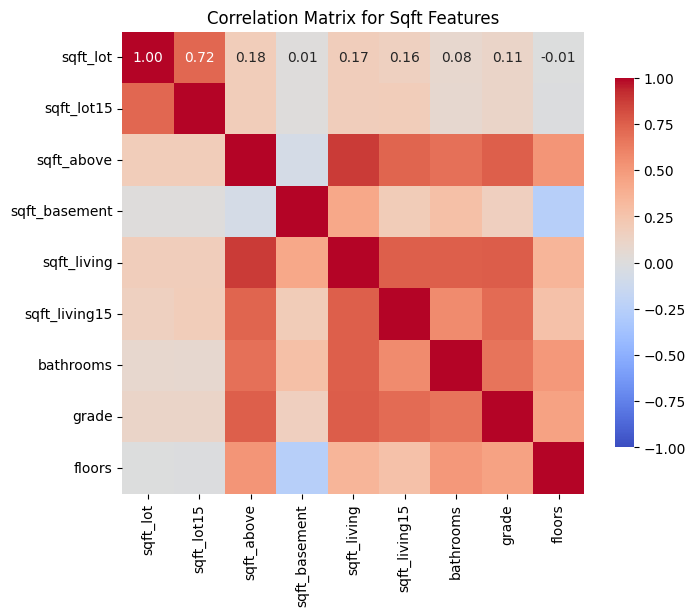

In [8]:
features_with_sqft = ['sqft_lot', 'sqft_lot15', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15', 'bathrooms', 'grade', 'floors']

# plot of correlation matrix for features with sqft
plt.figure(figsize=(8,6))
corr_matrix_sqft = df_train[features_with_sqft].corr()
sns.heatmap(corr_matrix_sqft, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, vmax=1.0, vmin=-1.0, center=0)
plt.title('Correlation Matrix for Sqft Features')
plt.show()

From below we can see that these features starting from 'sqrt' have almost the same distribution pattern as rest of the others. We can also see from the above correlation plot that most of them are heavily correlated with each other. Hence we use PCA for generating optimal fetures. Sqft_lot and Sqft_lot15 have a very high correlation between them. Sqft Basement does not have a very high correlation with any of them because most observations are 0. After That most of the values are quite correlated between each other.

In [9]:
features_with_time = ['yr_built', 'yr_renovated', 'condition', 'view']

# plot of correlation matrix for features with sqft
plt.figure(figsize=(8,6))
corr_matrix_time = df_train[features_with_time].corr()
sns.heatmap(corr_matrix_time, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, vmax=1.0, vmin=-1.0, center=0)
plt.title('Correlation Matrix for Time Features')
plt.show()

Fairly fine here!

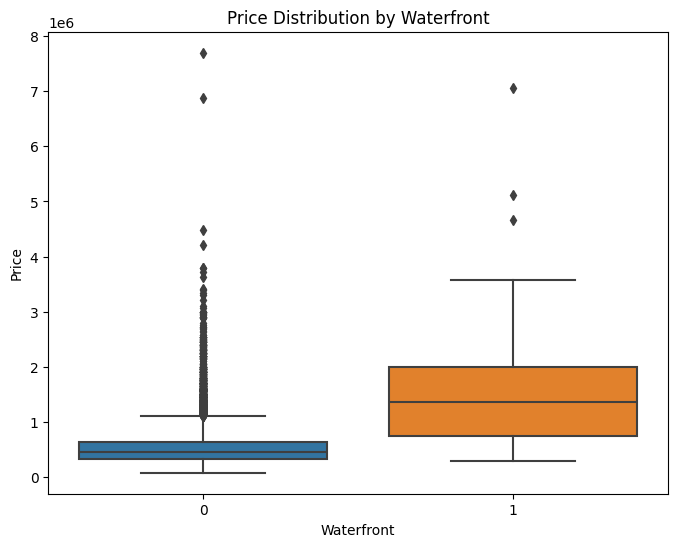

Text(0.5, 1.0, 'Price Distribution by View')

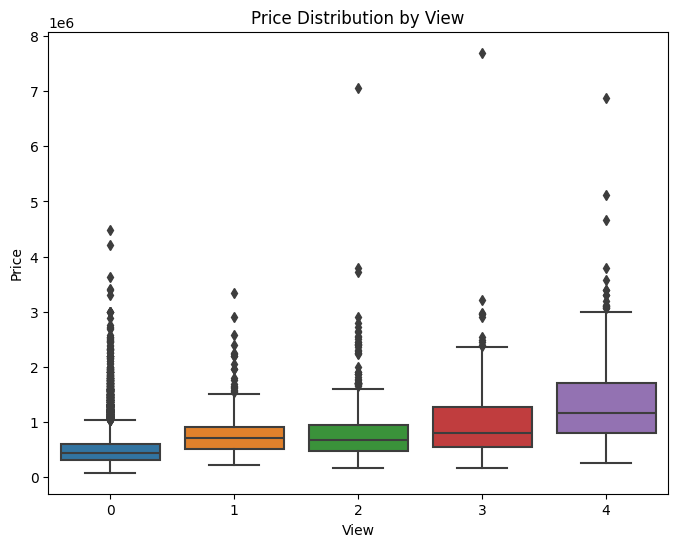

In [38]:
# relationship of waterfront and price
plt.figure(figsize=(8,6))
sns.boxplot(x='waterfront', y='price', data=df_train)
plt.title('Price Distribution by Waterfront')
plt.xlabel('Waterfront')
plt.ylabel('Price') 
plt.show()

# relationship with view and price
plt.figure(figsize=(8,6))
sns.boxplot(x='view', y='price', data=df_train)
plt.xlabel('View')
plt.ylabel('Price') 
plt.title('Price Distribution by View')

Text(0.5, 1.0, 'PCA Explained Variance')

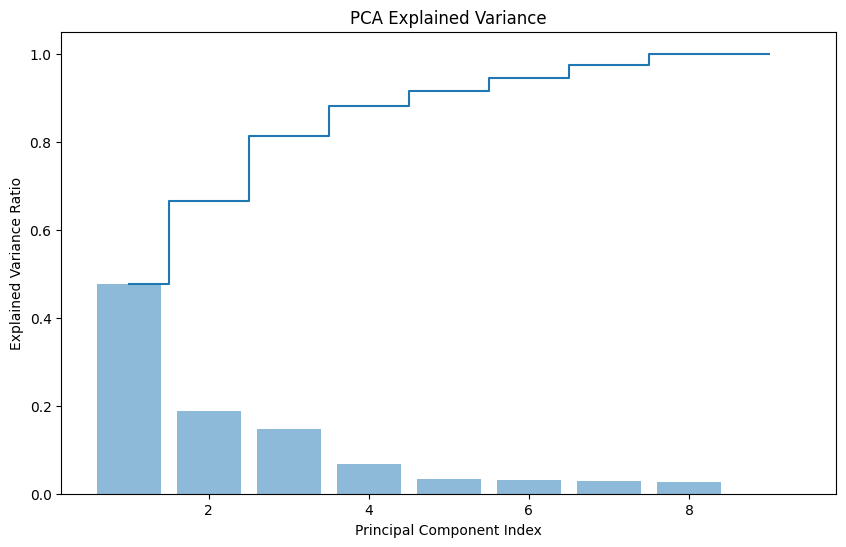

In [10]:
# Exploratory Factor Analysis
scaler_1 = StandardScaler()
X_scaled = scaler_1.fit_transform(df_train[features_with_sqft])   
pca = PCA()
pca.fit(X_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
plt.figure(figsize=(10,6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')

Text(0.5, 1.0, 'PCA Explained Variance')

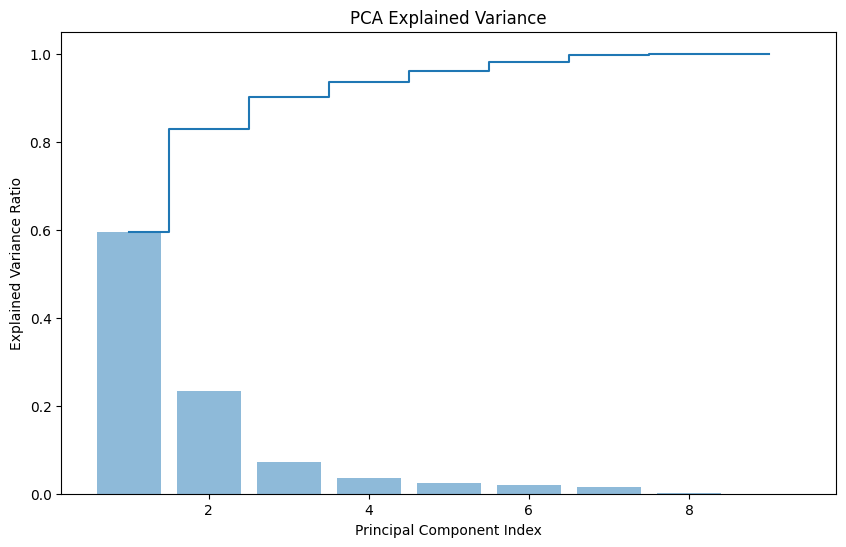

In [11]:
# Exploratory Factor Analysis
scaler_2 = MinMaxScaler()
X_scaled = scaler_2.fit_transform(df_train[features_with_sqft])   
pca = PCA()
pca.fit(X_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
plt.figure(figsize=(10,6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

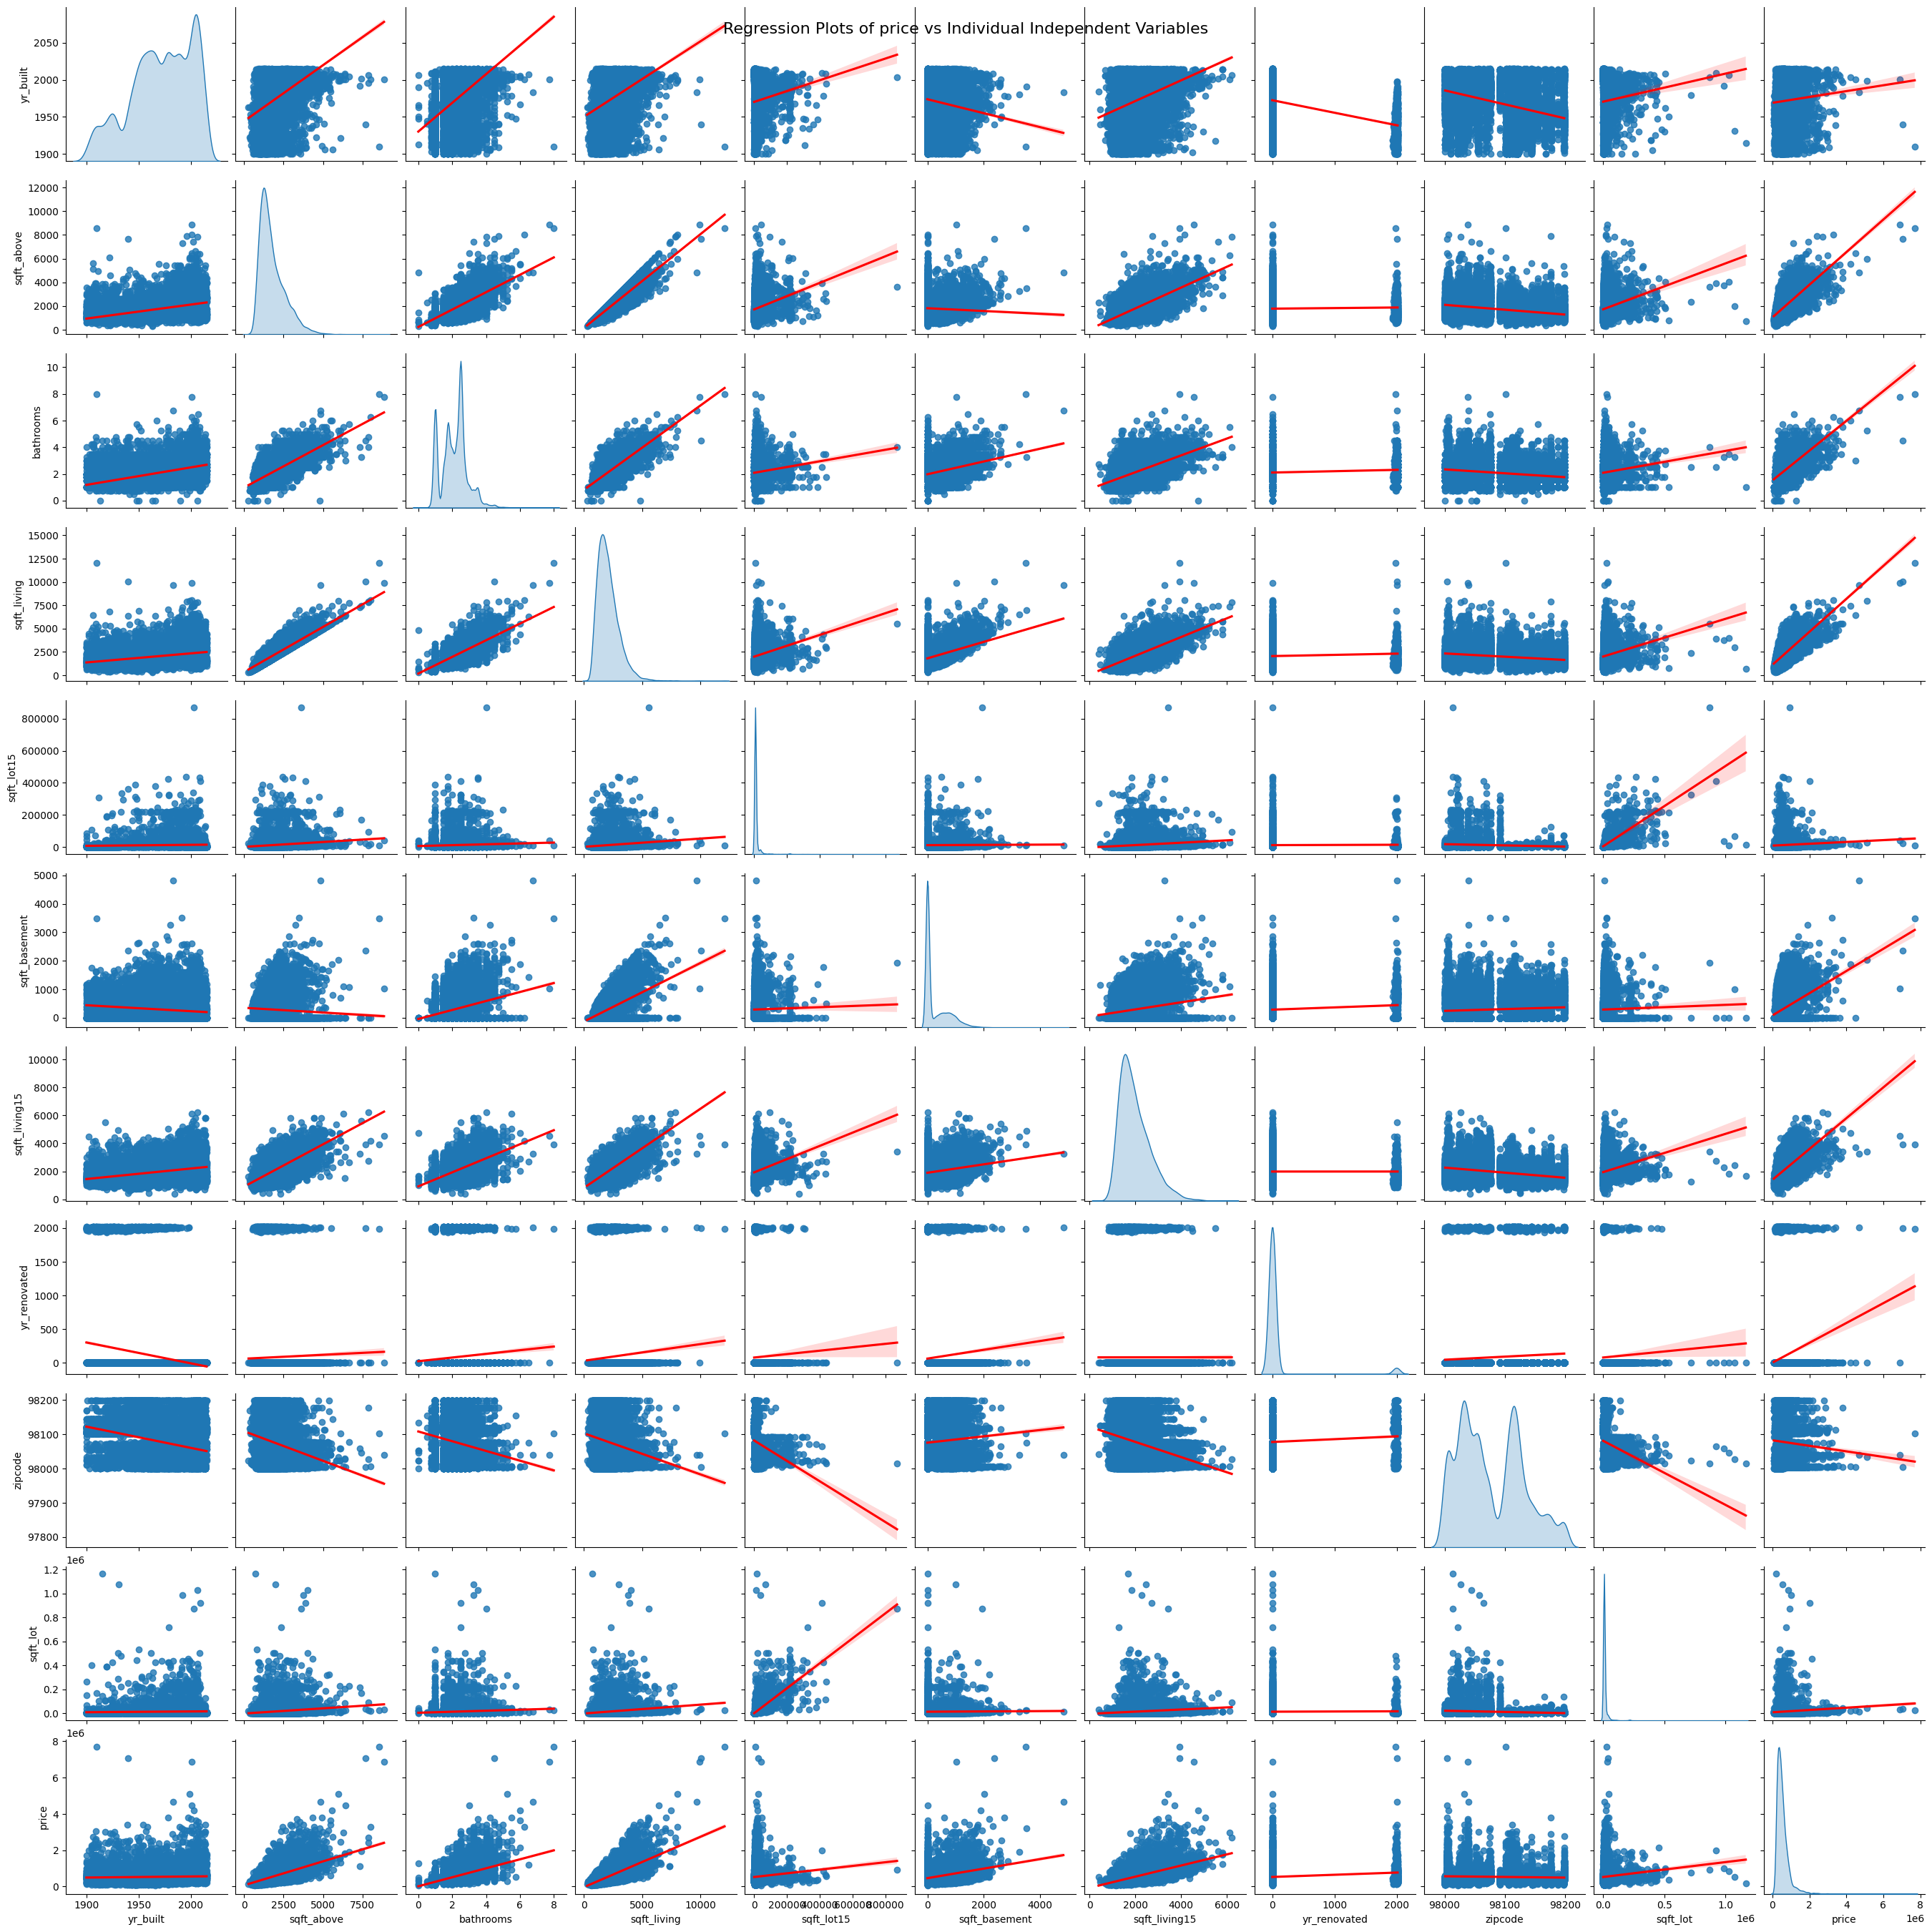

In [15]:
# Plots of price with different features
sns.pairplot(data=df_train[list(set(features_num) - set(categorical_features)) + [target]], 
             #x_vars=list(set(features_num) - set(categorical_features)), 
             #y_vars=target,
             kind='reg',
             diag_kind='kde',
             plot_kws={'line_kws':{'color':'red'}},
             #height=2.5,  # Adjust height of each plot
            )  # Adjust aspect ratio of each plot

# Add titles and adjust layout
#plt.subplots_adjust(top=0.9)
plt.suptitle(f'Regression Plots of {target} vs Individual Independent Variables', fontsize=16)
plt.show()

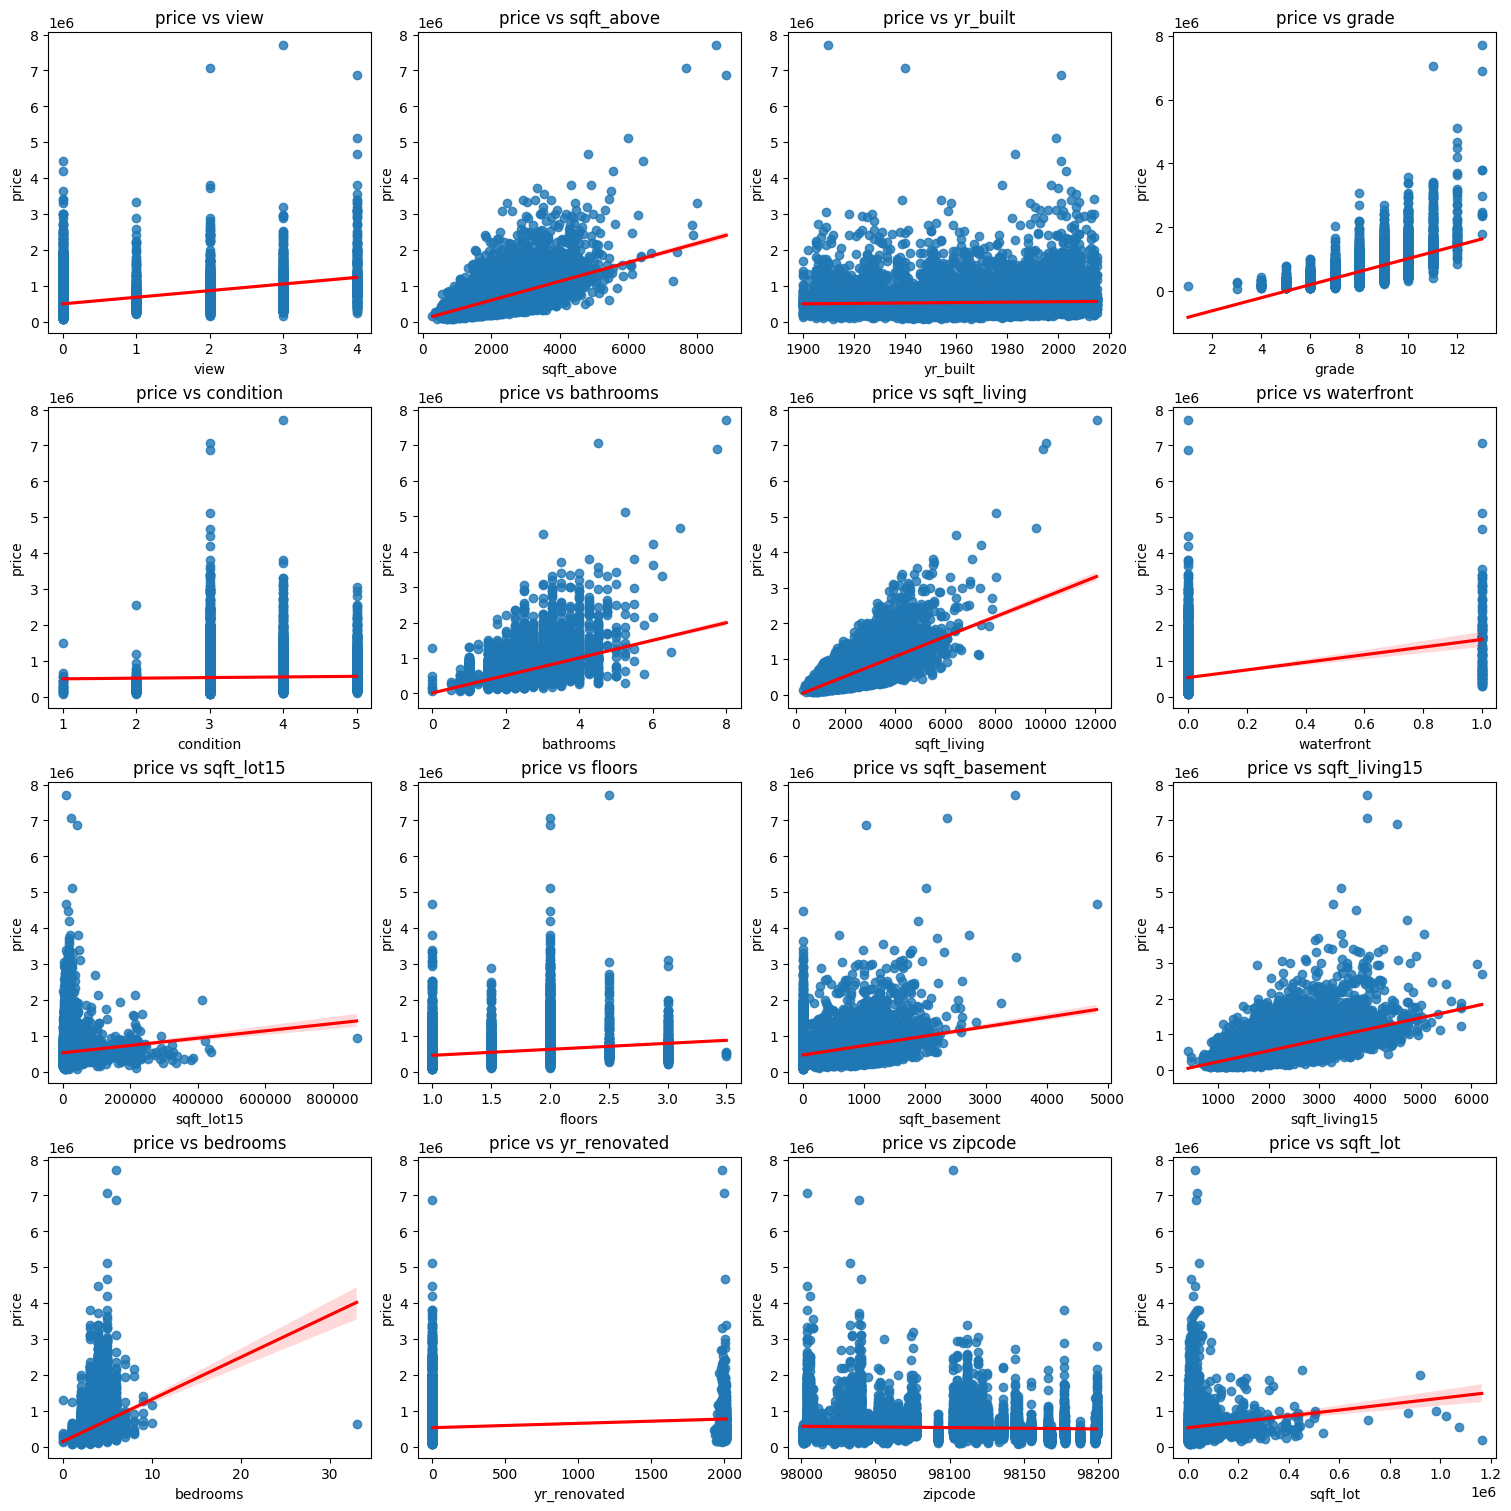

In [16]:
dependent_variable = target
independent_variables = features_num 
num_plots = len(independent_variables)
rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 15), constrained_layout=True)
axes = axes.flatten()

for i, feature in enumerate(independent_variables):
    # Use seaborn.regplot on the specific axis (ax)
    sns.regplot(x=feature, y=dependent_variable, data=df_train, ax=axes[i], ci=95, line_kws={'color':'red'})
    axes[i].set_title(f'{dependent_variable} vs {feature}')
    #axes[i].grid(True)

# 4. Hide unused subplots if the number of features is less than 16
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

# 5. Display the plot
plt.show()


Interesting points to notice - 

<ol> 
<li> Zip Code and Price do not have any strong relationship
</ol>

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

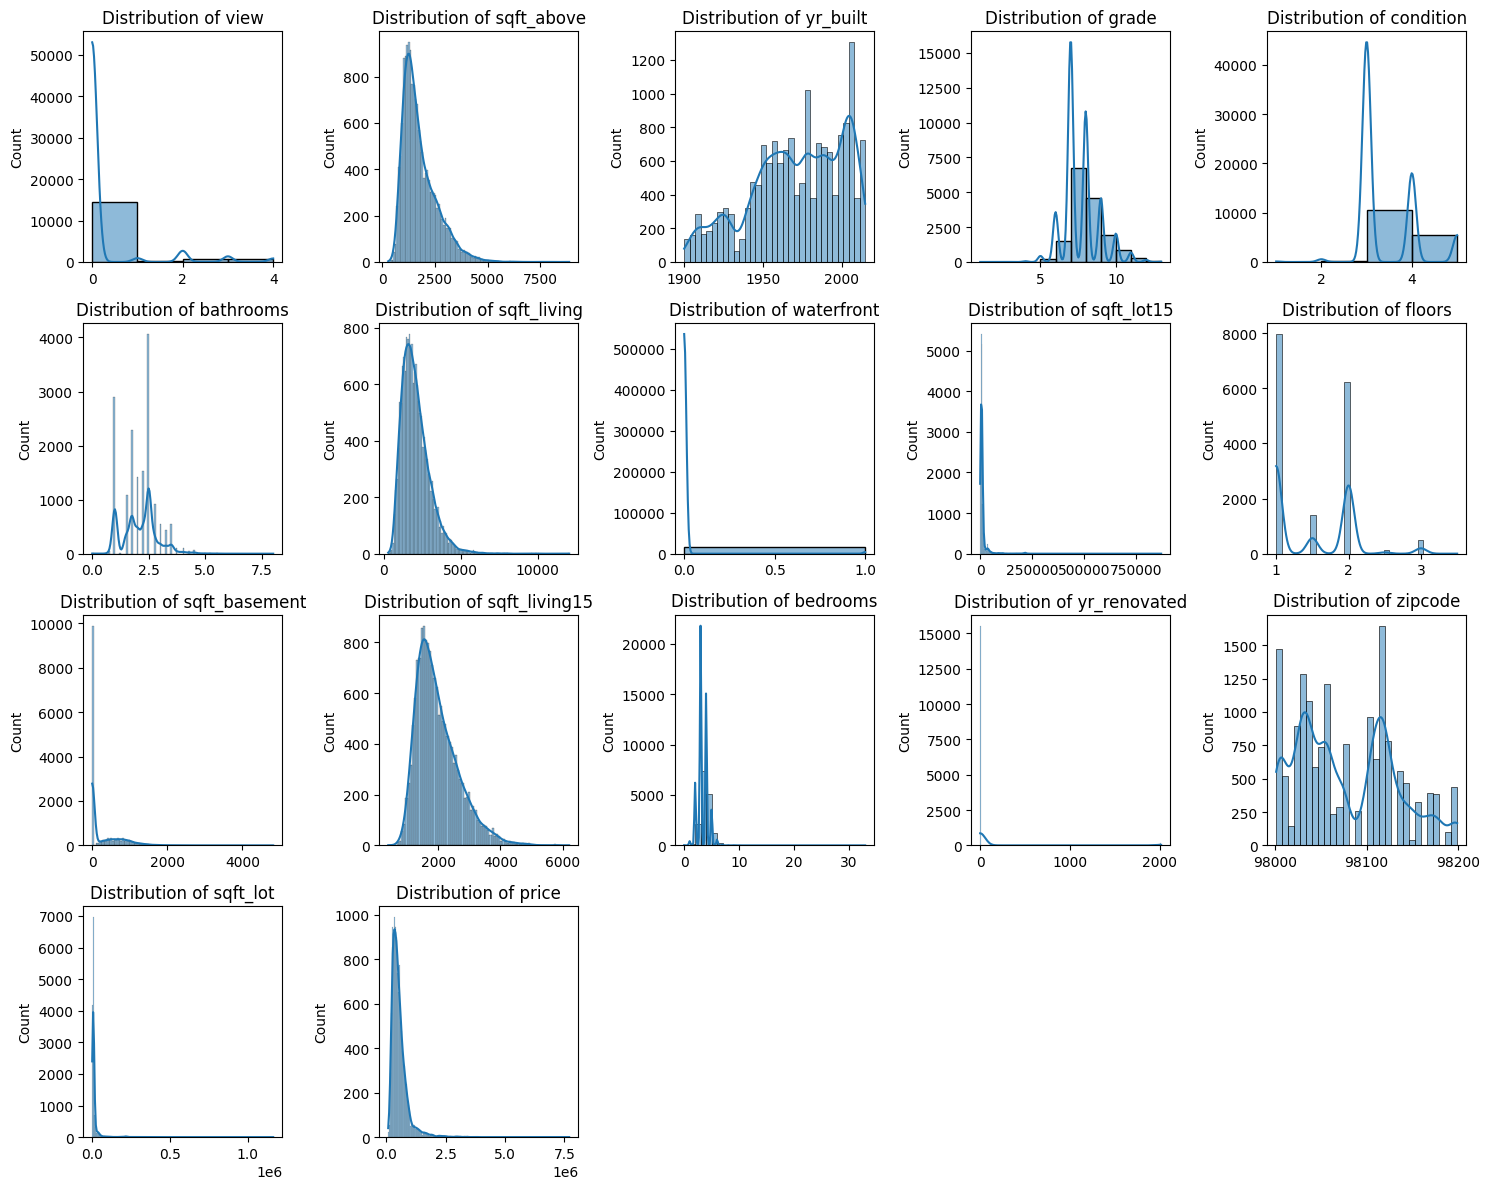

In [17]:
num_vars = 17
num_rows = 100
ROWS = 4
COLS = 5

fig, axes = plt.subplots(ROWS, COLS, figsize=(15, 12)) 
axes_flat = axes.flatten()

for i, col in enumerate(features_num + [target]):
    # Use seaborn's histplot (or displot for older versions)
    sns.histplot(df_train[col], kde=True, ax=axes_flat[i])
    axes_flat[i].set_title(f'Distribution of {col}')
    axes_flat[i].set_xlabel('') # Optional: clear x-labels for better spacing

for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()

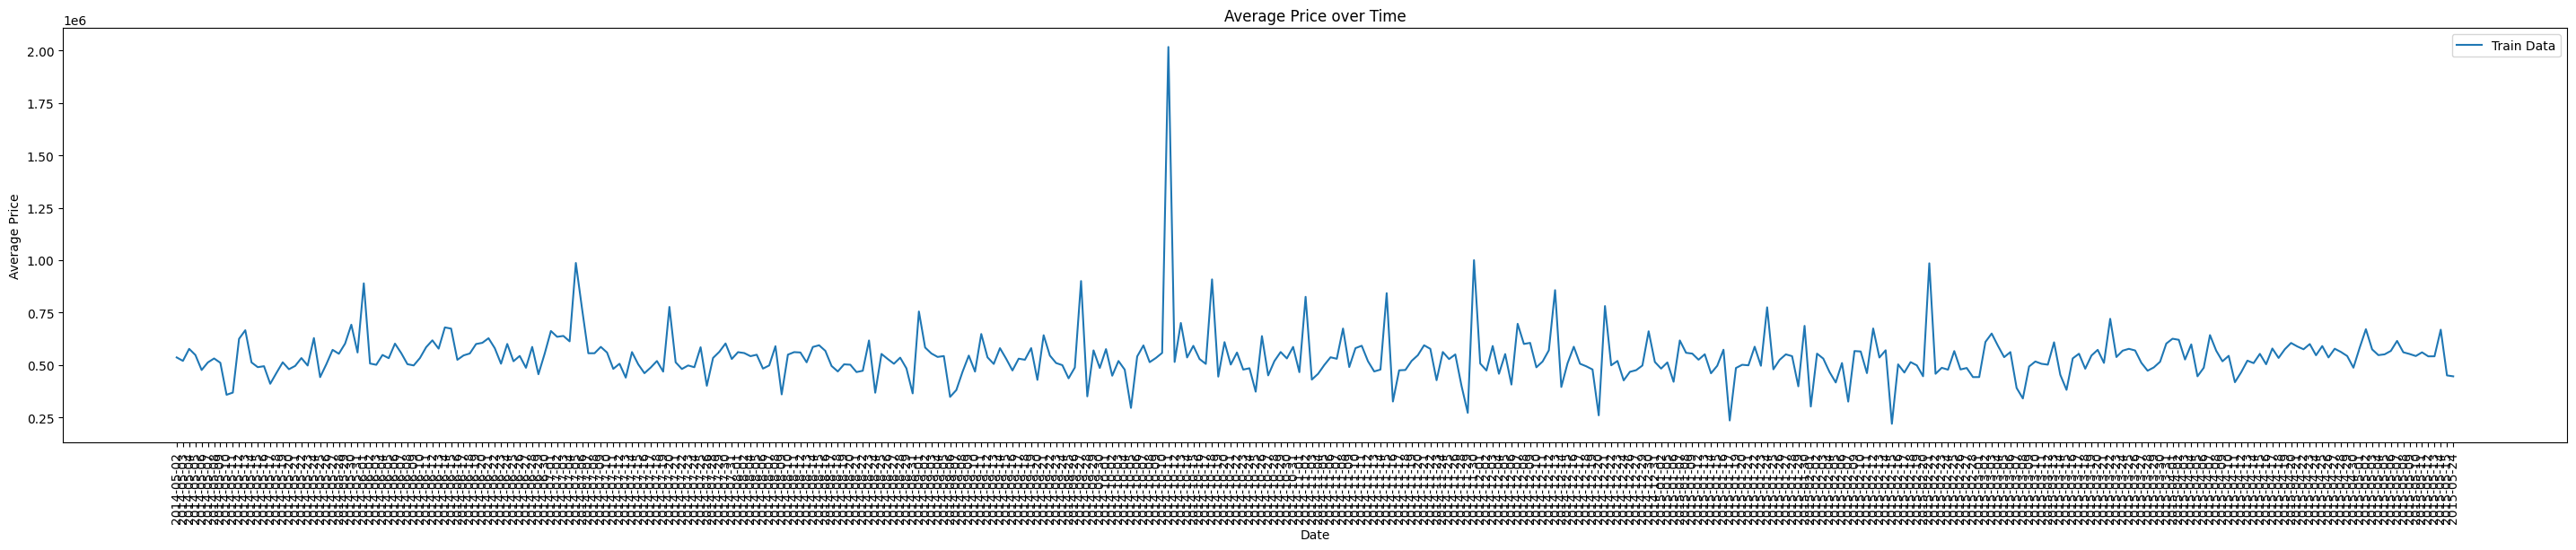

In [11]:
# temporal distribution of price over time
unique_dates_train = df_train['date'].unique()
avg_price_per_date_train = df_train.groupby('date')['price'].mean()

plt.figure(figsize=(36,6))
plt.plot(unique_dates_train, avg_price_per_date_train, label='Train Data')
plt.xlabel('Date')
plt.xticks(rotation=90) # rotating the date labels for better visibility
plt.ylabel('Average Price')
plt.title('Average Price over Time')
plt.legend()
plt.show()

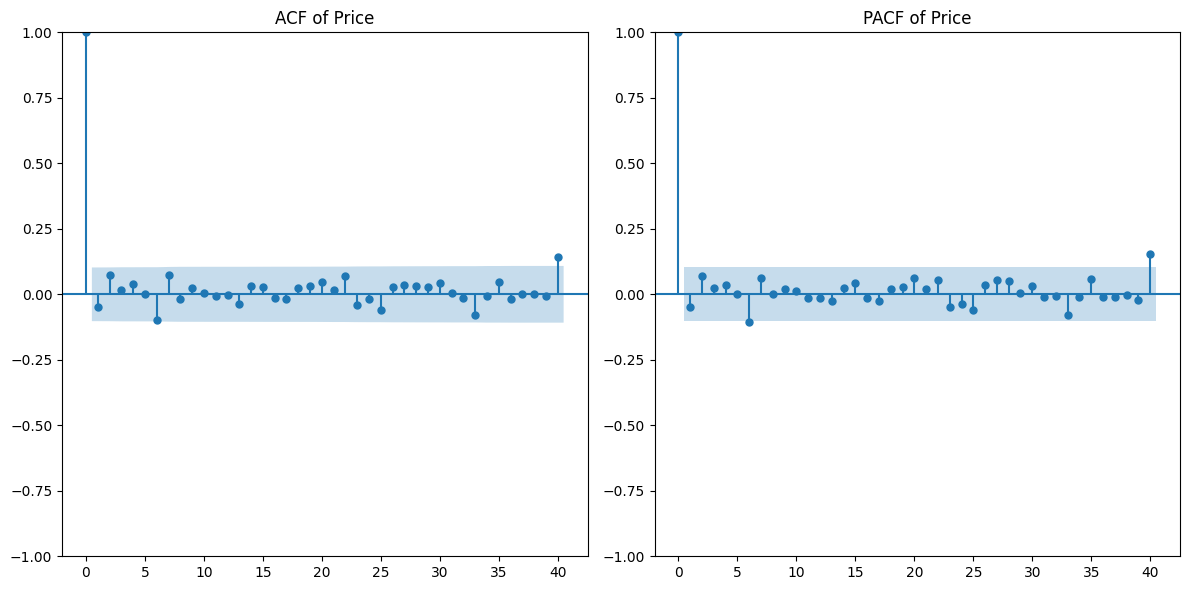

In [19]:
# plot ACF and PACF plots for target variable 'price'
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)  
plot_acf(avg_price_per_date_train, ax=plt.gca(), lags=40)
plt.title('ACF of Price')
plt.subplot(1,2,2)  
plot_pacf(avg_price_per_date_train, ax=plt.gca(), lags=40)
plt.title('PACF of Price')
plt.tight_layout()
plt.show()

There is no recurrent dependence of price on itself, infact the data is quite well behaved to be open source data, data seems to be quite well manicured

In [14]:
# temporal tests of price over time
avg_price_abs = df_train['price'].mean()
std_price_abs = df_train['price'].std()
avg_ofavg_price = avg_price_per_date_train.mean()
std_ofavg_price = avg_price_per_date_train.std()

print("Average Price:", avg_price_abs)
print("Standard Deviation of Price:", std_price_abs)
print("Average of Average Prices:", avg_ofavg_price)
print("Standard Deviation of Average Prices:", std_ofavg_price)

# print stationarity tests 
print("===========AD Fuller Test Results===========")
adf_result = adfuller(df_train['price'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print('Critical Value ({}): {:.3f}'.format(key, value))
if adf_result[1] < 0.05:
    print("The time series is stationary according to the ADF test.")
else:
    print("The time series is non-stationary according to the ADF test.")

print("===========KPSS Test Results===========")
kpss_result = kpss(df_train['price'], regression='c')
print("KPSS Statistic:", kpss_result[0])
print("p-value:", kpss_result[1])
for key, value in kpss_result[3].items():
    print('Critical Value ({}): {:.3f}'.format(key, value))
if kpss_result[1] < 0.05:
    print("The time series is non-stationary according to the KPSS test.")
else:
    print("The time series is stationary according to the KPSS test.")

Average Price: 537470.2827441545
Standard Deviation of Price: 360303.57735673117
Average of Average Prices: 539332.6290016476
Standard Deviation of Average Prices: 126704.35988934166
===========AD Fuller Test Results===========
ADF Statistic: -41.61835180029532
p-value: 0.0
Critical Value (1%): -3.431
Critical Value (5%): -2.862
Critical Value (10%): -2.567
The time series is stationary according to the ADF test.
===========KPSS Test Results===========
KPSS Statistic: 0.4466722717582481
p-value: 0.05703781389730687
Critical Value (10%): 0.347
Critical Value (5%): 0.463
Critical Value (2.5%): 0.574
Critical Value (1%): 0.739
The time series is stationary according to the KPSS test.


There is no temporal Shock to the price, nor is there any trend or any other important feature about price

In [21]:
# cointegration among features
coint_features = []

for feature in features_num:
    coint_result = coint(df_train['price'], df_train[feature])
    print(f"Cointegration test between price and {feature}:")
    print("t-statistic:", coint_result[0])
    if coint_result[0] < coint_result[2][1]:  # using 5% critical value
        print("The series are cointegrated for price and ", feature) 
        coint_features.append(feature)  
    else:
        print("The series are not cointegrated for price and ", feature)

Cointegration test between price and view:
t-statistic: -50.68749364596719
The series are cointegrated for price and  view
Cointegration test between price and sqft_above:
t-statistic: -41.00235892805979
The series are cointegrated for price and  sqft_above
Cointegration test between price and yr_built:
t-statistic: -41.66086971325869
The series are cointegrated for price and  yr_built
Cointegration test between price and grade:
t-statistic: -50.34052445798419
The series are cointegrated for price and  grade
Cointegration test between price and condition:
t-statistic: -41.61326072682845
The series are cointegrated for price and  condition
Cointegration test between price and bathrooms:
t-statistic: -51.62913199792232
The series are cointegrated for price and  bathrooms
Cointegration test between price and sqft_living:
t-statistic: -31.53675396312234
The series are cointegrated for price and  sqft_living
Cointegration test between price and waterfront:
t-statistic: -51.256696148817625
T

In [ ]:
# Spatial Feature effects

# Spatial weight matrix

def distance_matrix_1(latitudes, longitudes, threshold = 0.4) -> np.ndarray:
    # decalre location indices
    coords = np.array(list(zip(latitudes, longitudes)))
    matrix = distance_matrix(coords, coords, threshold=threshold)
    filter = threshold  # distance threshold in same units as lat/long
    weight_matrix = np.where(matrix >= filter, 1, 0)
    np.fill_diagonal(weight_matrix, 0)  # no self-loops
    return weight_matrix

#weight_matrix = distance_matrix_1(df_train['lat'], df_train['long'], threshold=0.7) (already eecuted)

# visualizing the weight matrix
#plt.figure(figsize=(10,8))
#sns.heatmap(weight_matrix, cmap='viridis')
#plt.title('Spatial Weight Matrix based on Distance')
#plt.xlabel('Observations')
#plt.ylabel('Observations')
#plt.show()

# saving the weight matrix for future use
#np.savetxt(data_path + '/spatial_weight_matrix.csv', weight_matrix, delimiter=',')

#Moran's I calculation for spatial autocorrelation
# load weight matrix
#weight_matrix = np.loadtxt(data_path + '/spatial_weight_matrix.csv', delimiter=',')

#Moran's I calculation for spatial autocorrelation

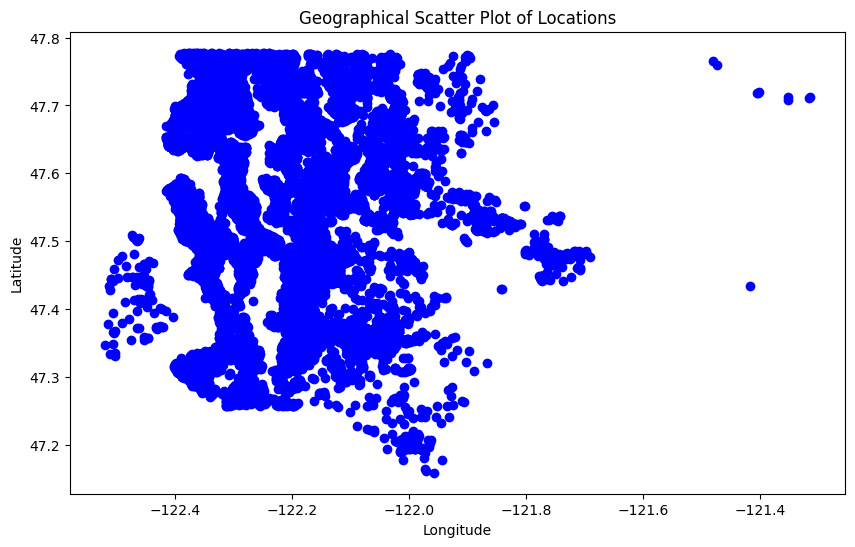

In [12]:
# Scatter plot of lat and long
plt.figure(figsize=(10,6))
plt.scatter(df_train['long'], df_train['lat'], c='blue')
plt.title('Geographical Scatter Plot of Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

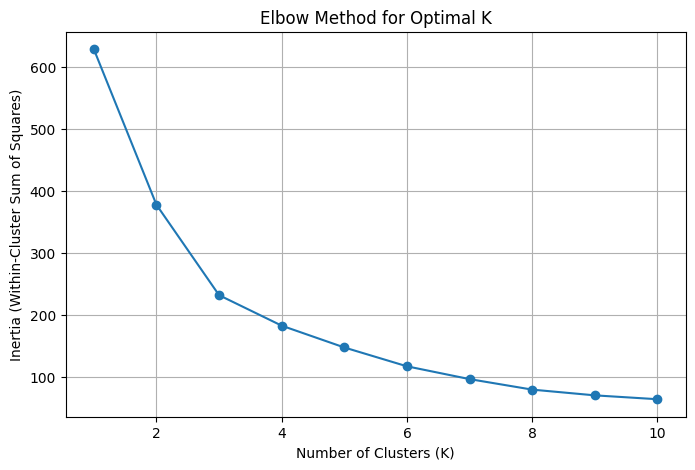

In [13]:
#Spatial Features using KNN and Unsupervised learning + effects of spatial fetures on price

X = df_train[['lat', 'long']].values

# List to store inertia values for different k
inertia = []

# Range of K values to test
K_range = range(1, 11)

# Fit the KMeans model for each K
for k in K_range:
    # Initialize KMeans with 'k-means++' for robust centroid seeding
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X)
    # Append the inertia (WCSS) to the list
    inertia.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

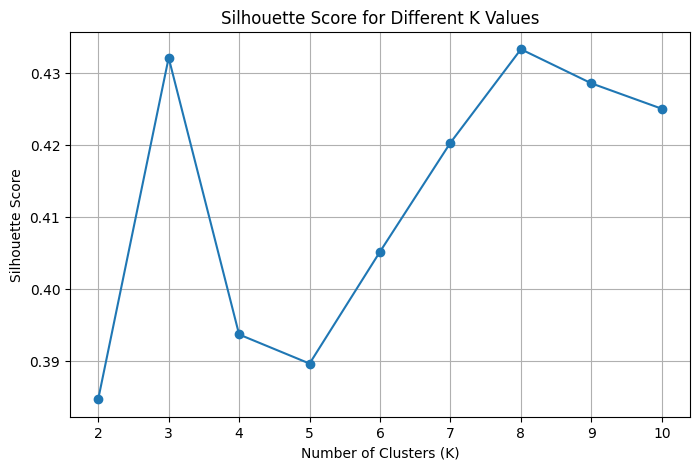

In [15]:
# Silohouette Score for different K values
silhouette_scores = []
K_range = range(2, 11)  # Silhouette score is not defined for K=1
for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Score for Different K Values')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

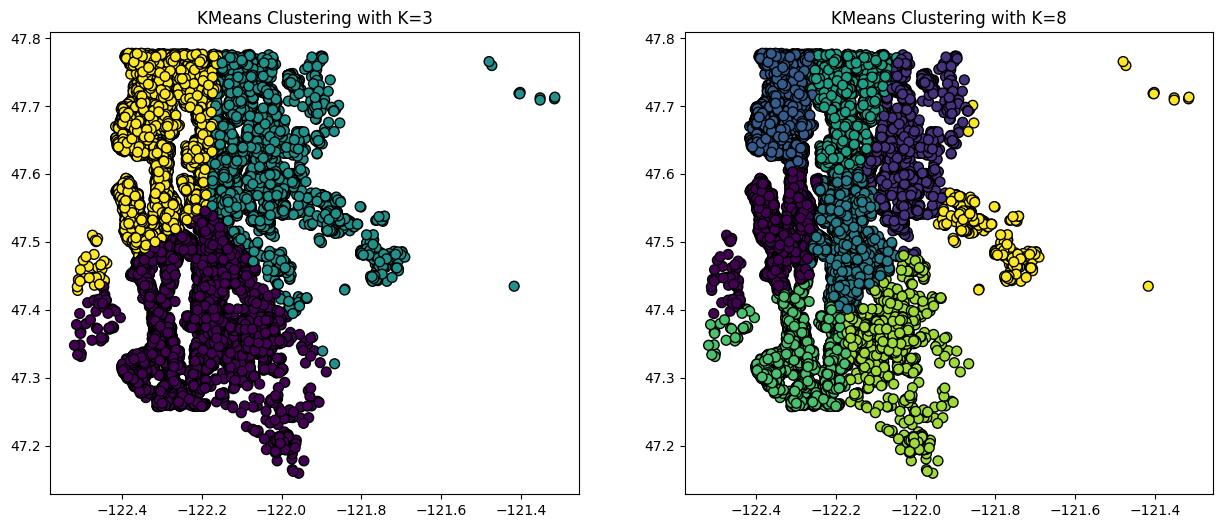

In [ ]:
# plotting with 3 clustering and 8 clustering
k_values = [3, 8]
fig, axes = plt.subplots(1, 2, figsize=(15, 6)) 
for ax, k in zip(axes, k_values):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X)
    ax.scatter(X[:, 1], X[:, 0], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
    ax.set_title(f'KMeans Clustering with K={k}')

In [16]:
# attaching this to the original dataframe
df_train['spatial_cluster_8'] = KMeans(n_clusters=8, init='k-means++', random_state=42, n_init=10).fit_predict(X)

While this is not completely helpful, the sharpness of fall reduces after the 3rd cluster or 8th cluster, we will use DBSCAN as it is the best for clustering.

In [25]:
#DBSCAN clustering and evaluation
eps_values = [0.001, 0.01, 0.02, 0.0214,0.022, 0.025, 0.03, 0.1]
min_samples = 5
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X)
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    print(f"DBSCAN with eps={eps}: Number of clusters = {n_clusters}")

DBSCAN with eps=0.001: Number of clusters = 79
DBSCAN with eps=0.01: Number of clusters = 42
DBSCAN with eps=0.02: Number of clusters = 13
DBSCAN with eps=0.0214: Number of clusters = 8
DBSCAN with eps=0.022: Number of clusters = 5
DBSCAN with eps=0.025: Number of clusters = 4
DBSCAN with eps=0.03: Number of clusters = 2
DBSCAN with eps=0.1: Number of clusters = 2


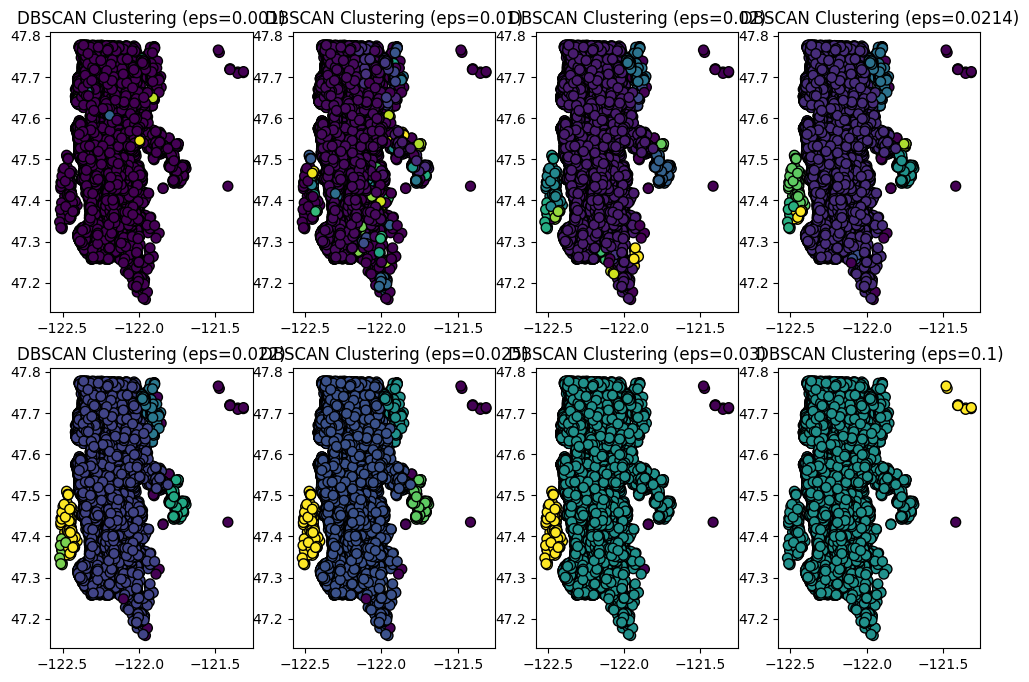

In [27]:
# plot DBSCAN clustering and evaluation
plt.figure(figsize=(12, 8))
for i, eps in enumerate(eps_values):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X)
    plt.subplot(2, 4, i + 1)
    plt.scatter(X[:, 1], X[:, 0], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
    plt.title(f'DBSCAN Clustering (eps={eps})')

DBSCAN was not useful atall.

Mean Price per Spatial Cluster (K=8):


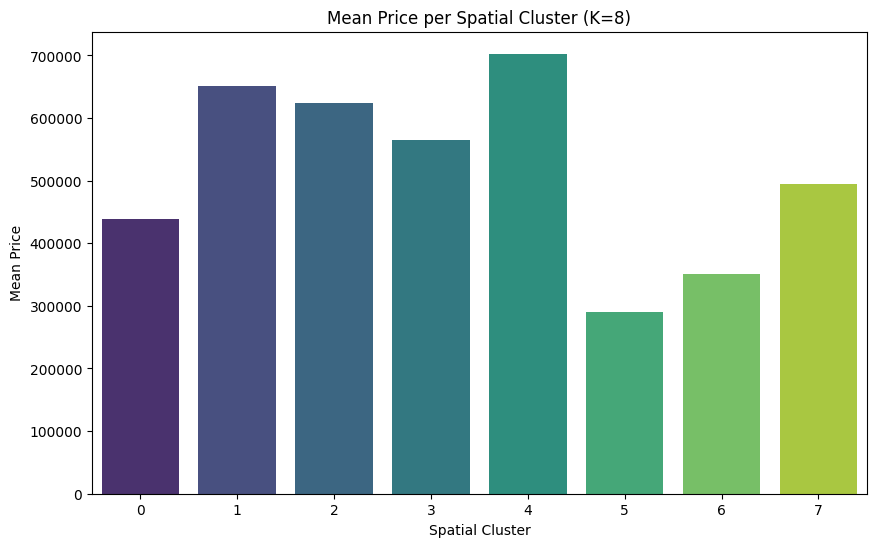

In [29]:
# mean price per location cluster
mean_price_per_cluster = df_train.groupby('spatial_cluster_8')['price'].mean()

print("Mean Price per Spatial Cluster (K=8):")

# bar graph for each cluster
plt.figure(figsize=(10,6))
sns.barplot(x=mean_price_per_cluster.index, y=mean_price_per_cluster.values, palette='viridis')
plt.title('Mean Price per Spatial Cluster (K=8)')
plt.xlabel('Spatial Cluster')
plt.ylabel('Mean Price')
plt.show()

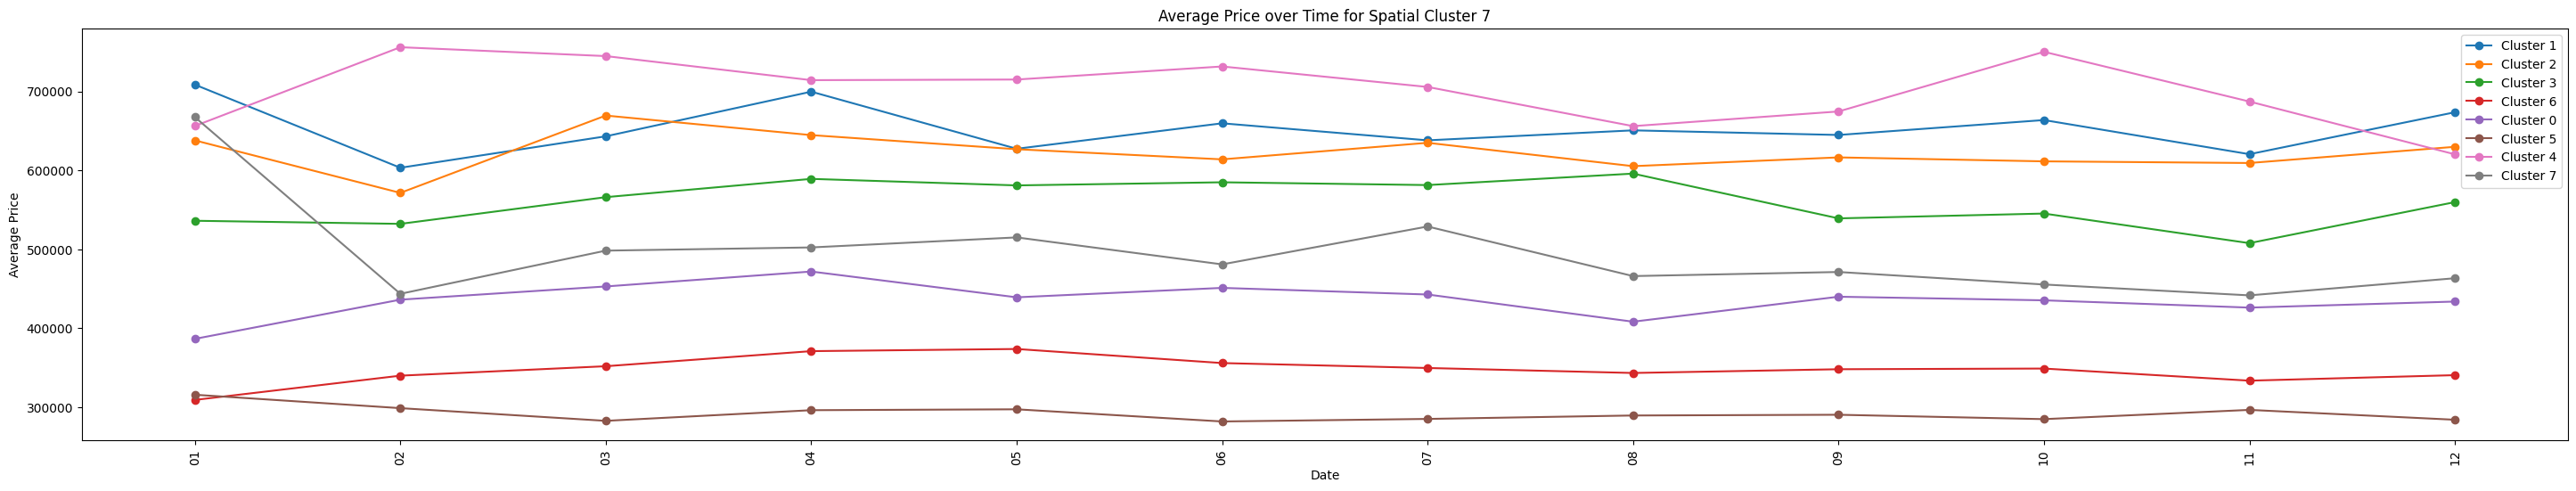

In [ ]:
# Spatio-temporal Analysis and Feature effects
 
plt.figure(figsize=(36,6))

for cluster in df_train['spatial_cluster_8'].unique():
    cluster_data = df_train[df_train['spatial_cluster_8'] == cluster]
    avg_price_per_date = cluster_data.groupby('date')['price'].mean()
    # average price per month of the year
    avg_price_per_month = cluster_data.groupby(cluster_data['date'].str.slice(5,7))['price'].mean()

    plt.plot(avg_price_per_month.index, avg_price_per_month.values, marker='o', linestyle='-' , label=f'Cluster {cluster}')

plt.xlabel('Date')
plt.xticks(rotation=90) # rotating the date labels for better visibility
plt.ylabel('Average Price')
plt.title(f'Average Price over Time for Spatial Cluster {cluster}')
plt.legend()
plt.show()

Hence we clearly see that there is a variation in the price because of the location where the property may be located, as observed feom the average price permonth of the cluster of location

Feature Importances from Random Forest:
          Feature  Importance
6           grade    0.375138
2     sqft_living    0.251876
9        yr_built    0.093747
10        zipcode    0.082984
11  sqft_living15    0.058965
12     sqft_lot15    0.030872
3        sqft_lot    0.025757
7      sqft_above    0.024764
1       bathrooms    0.021780
8   sqft_basement    0.012812
0        bedrooms    0.008024
5       condition    0.007810
4          floors    0.005471


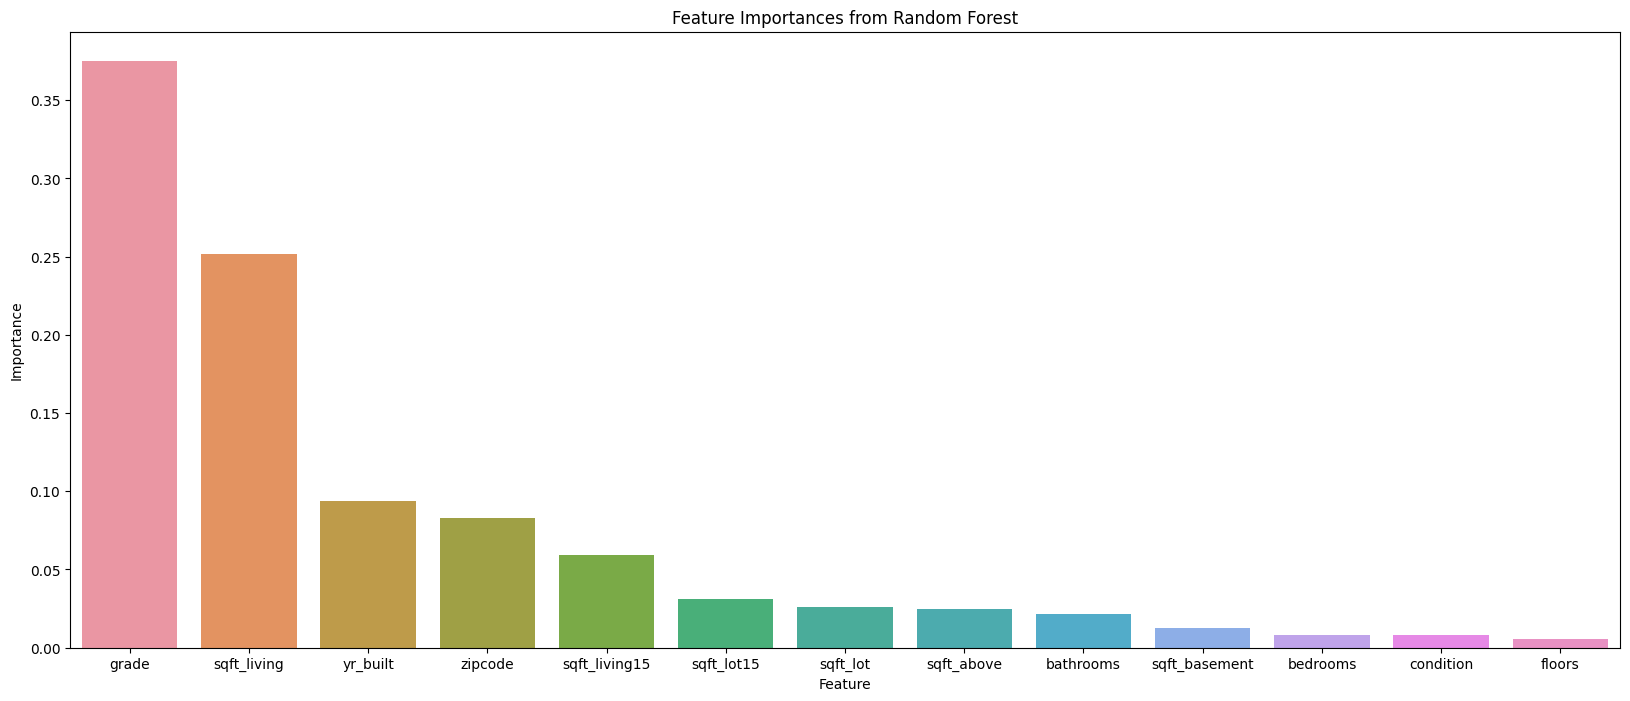

In [ ]:
# Double ML Model
# Causal Inference with Double ML useful for treatment effect estimation
# This allows us to train better and accurate models for predicting price

# Preparing data for Double ML
X = df_train.drop(columns=[target, 'date', 'id', 'lat', 'long', 'waterfront', 'view', 'yr_renovated']) # neutralizing Bias of too many zeros
y = df_train[target]

# Train Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Double ML with Random Forest
model_1 = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
model_1.fit(X_train, y_train)

#Feature Importance
importances = model_1.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances from Random Forest:")
print(feature_importance_df)

# Feature Importance Plot
plt.figure(figsize=(20, 8))
sns.barplot(x='Feature', y='Importance', data=feature_importance_df)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.show()

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.870e+14, tolerance: 1.657e+11
  model = cd_fast.enet_coordinate_descent(


Feature Importances from Ridge Regression:
          Feature     Importance
6           grade  120076.418114
1       bathrooms   45607.021581
4          floors   36810.220347
5       condition   18475.881609
2     sqft_living     117.167228
10        zipcode      85.765584
8   sqft_basement      70.449470
7      sqft_above      46.717309
11  sqft_living15      40.278932
3        sqft_lot       0.033776
12     sqft_lot15      -0.470544
9        yr_built   -3875.294667
0        bedrooms  -44982.882066
Feature Importances from Lasso Regression:
          Feature     Importance
6           grade  120094.124166
1       bathrooms   45620.722693
4          floors   36818.011074
5       condition   18479.850240
2     sqft_living     291.842621
10        zipcode      85.717902
11  sqft_living15      40.271725
3        sqft_lot       0.033776
12     sqft_lot15      -0.470500
8   sqft_basement    -104.237673
7      sqft_above    -127.978156
9        yr_built   -3875.574635
0        bedrooms  -449

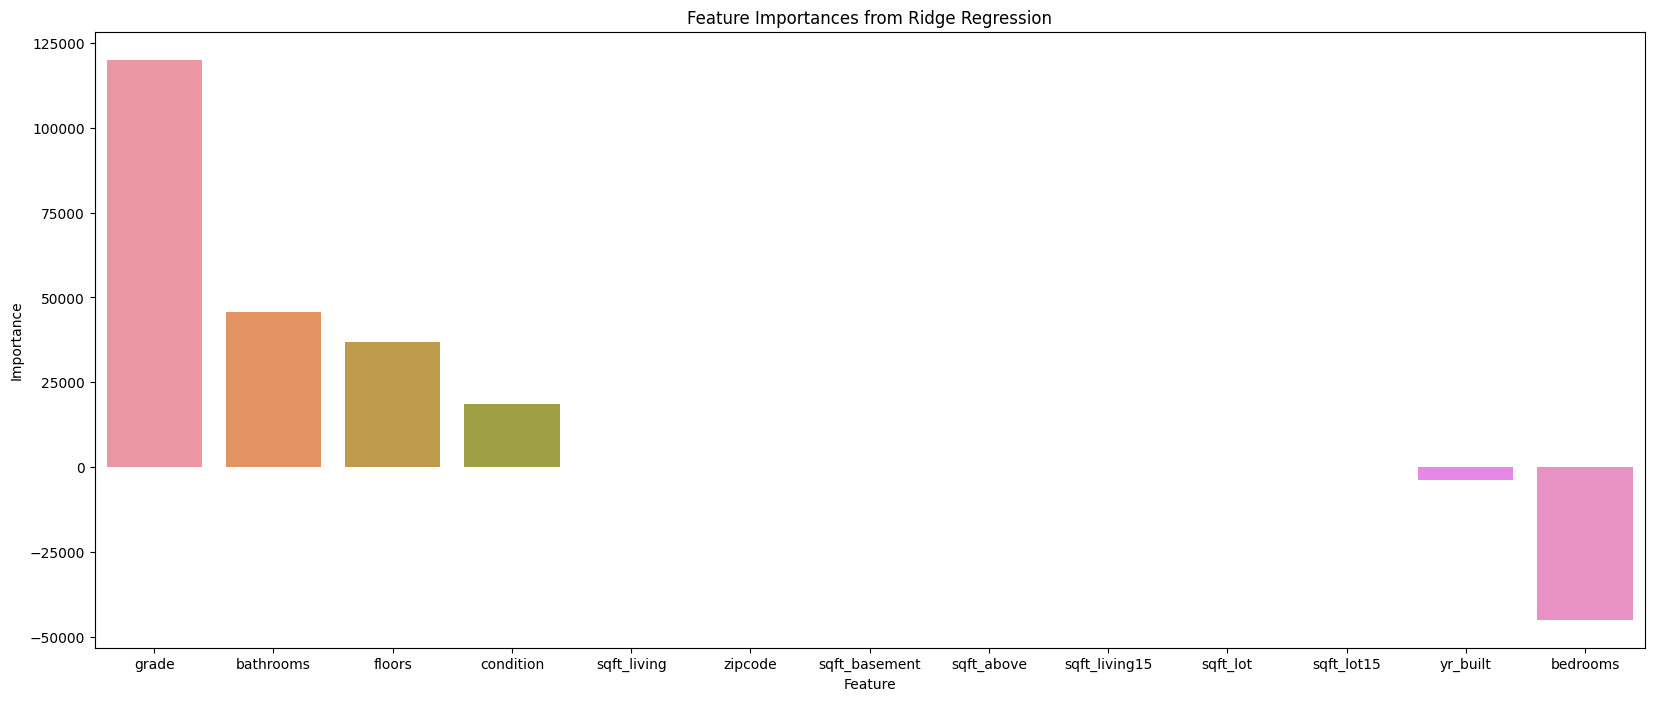

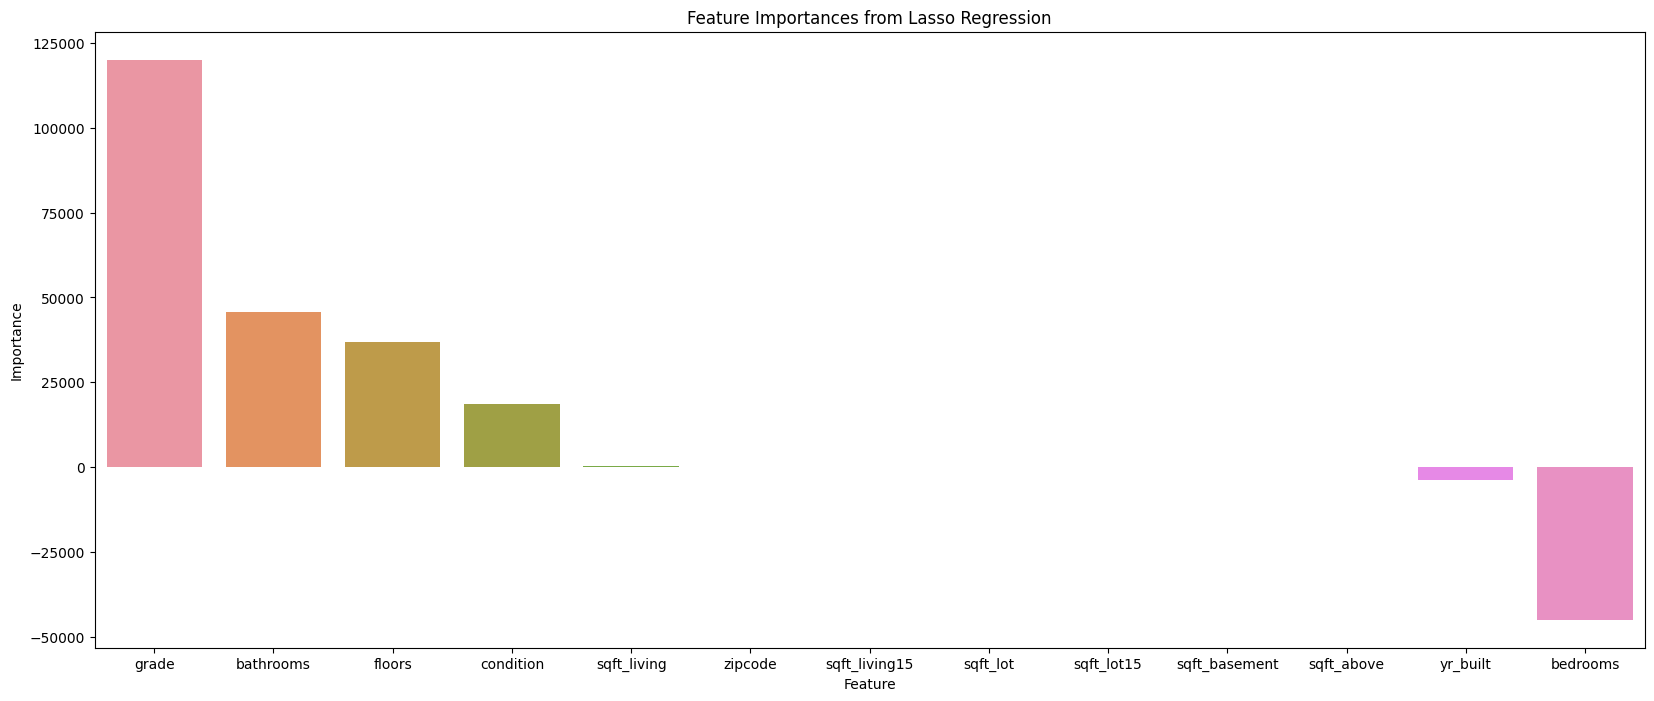

In [ ]:
# Feature importance with ridge and lasso regression
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.1)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)
ridge_importances = ridge.coef_
lasso_importances = lasso.coef_

ridge_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': ridge_importances})
ridge_importance_df = ridge_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances from Ridge Regression:")
print(ridge_importance_df)

lasso_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lasso_importances})
lasso_importance_df = lasso_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances from Lasso Regression:")
print(lasso_importance_df)

#plot feature importance for ridge
plt.figure(figsize=(20, 8))
sns.barplot(x='Feature', y='Importance', data=ridge_importance_df)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances from Ridge Regression')
plt.show()

#plot feature importance for lasso
plt.figure(figsize=(20, 8))
sns.barplot(x='Feature', y='Importance', data=lasso_importance_df)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances from Lasso Regression')
plt.show()

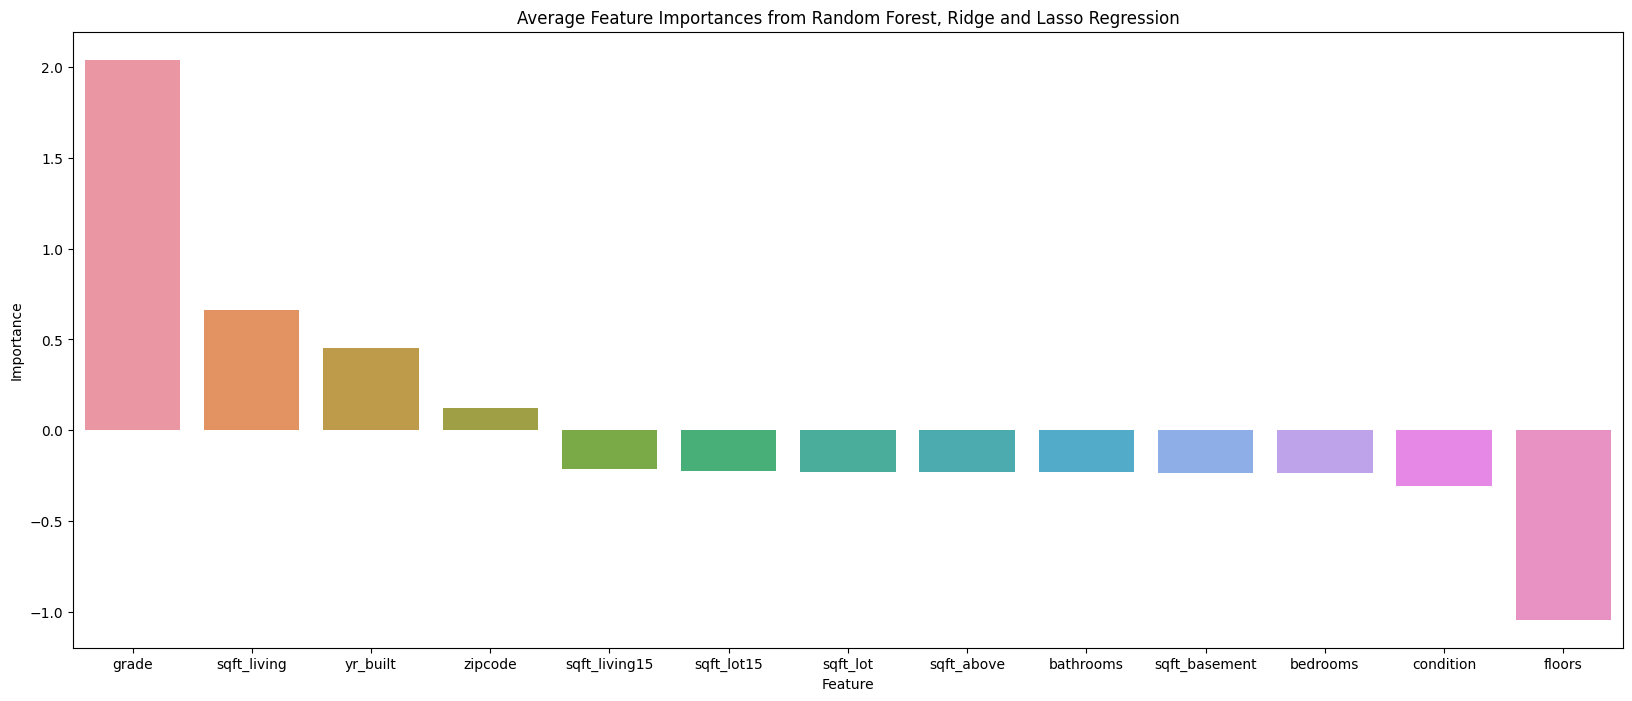

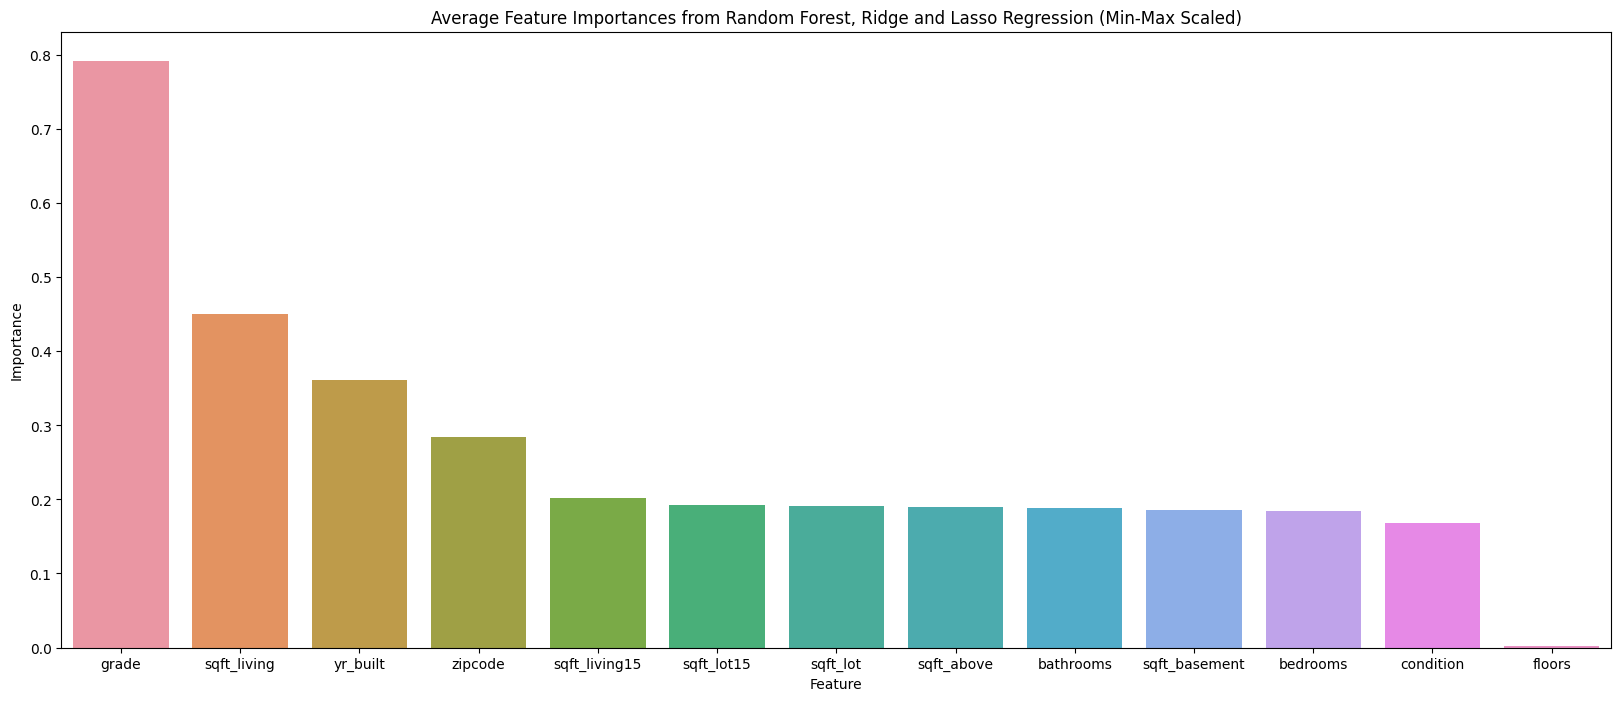

In [ ]:
#Average plot of all the importance graphs

Avegage_score_1 = (feature_importance_df.set_index('Feature') + scaler_1.fit_transform(ridge_importance_df.set_index('Feature')) + scaler_1.fit_transform(lasso_importance_df.set_index('Feature'))) / 3
Avegage_score_2 = (feature_importance_df.set_index('Feature') + scaler_2.fit_transform(ridge_importance_df.set_index('Feature')) + scaler_2.fit_transform(lasso_importance_df.set_index('Feature'))) / 3

#plot
Avegage_score = Avegage_score_1.reset_index()
plt.figure(figsize=(20, 8))
sns.barplot(x='Feature', y='Importance', data=Avegage_score)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Average Feature Importances from Random Forest, Ridge and Lasso Regression')
plt.show()

Avg_score = Avegage_score_2.reset_index()
plt.figure(figsize=(20, 8))
sns.barplot(x='Feature', y='Importance', data=Avg_score)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Average Feature Importances from Random Forest, Ridge and Lasso Regression (Min-Max Scaled)')
plt.show()

In [ ]:
df_train['date'].dtype

dtype('O')

In [ ]:
X.nunique()

bedrooms           12
bathrooms          29
sqft_living       881
sqft_lot         8048
floors              6
condition           5
grade              12
sqft_above        803
sqft_basement     280
yr_built          116
zipcode            70
sqft_living15     692
sqft_lot15       7279
dtype: int64

Feature Importances from Random Forest:
                Feature    Importance
2            pca_sqft_1  5.616708e-01
0              yr_built  8.062840e-02
1               zipcode  7.838663e-02
43  spatial_cluster_8_2  3.659675e-02
3            pca_sqft_2  3.294641e-02
5            pca_sqft_4  3.235095e-02
4            pca_sqft_3  2.981295e-02
46  spatial_cluster_8_5  2.084032e-02
22         waterfront_1  1.839337e-02
47  spatial_cluster_8_6  1.554305e-02
45  spatial_cluster_8_4  1.461255e-02
26               view_4  8.618706e-03
44  spatial_cluster_8_3  8.052409e-03
37              grade_9  7.093951e-03
54              perks_5  5.760543e-03
49          renovated_1  4.868980e-03
38             grade_10  3.905656e-03
36              grade_8  3.056651e-03
53              perks_4  2.750959e-03
28          condition_3  2.660613e-03
42  spatial_cluster_8_1  2.250245e-03
39             grade_11  2.139900e-03
9            bedrooms_4  1.835995e-03
10           bedrooms_5  1.831688e-03
18        

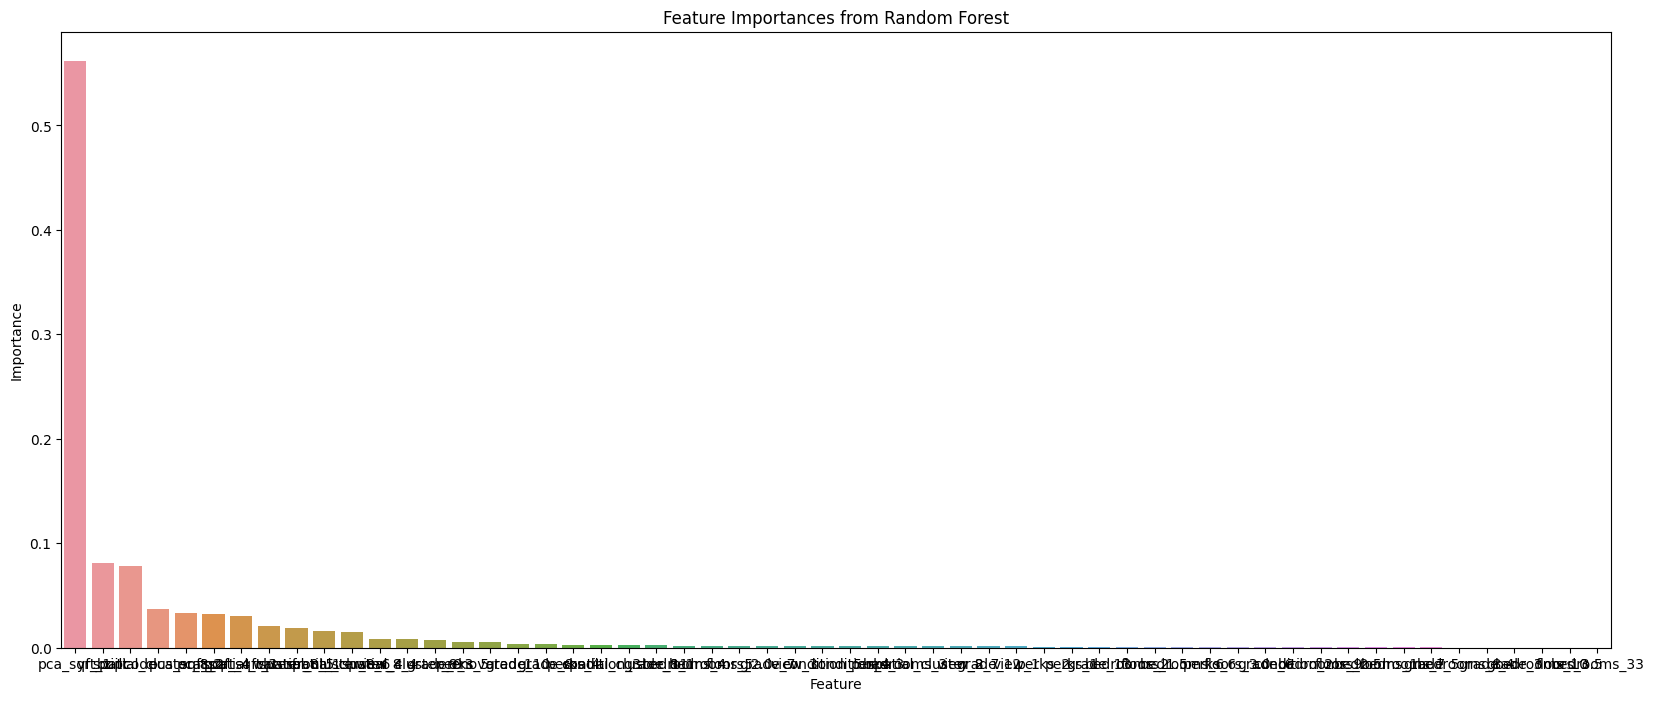

In [19]:
df_train_encoded = pd.read_csv(data_path + '/encoded_train.csv')

# Preparing data for Double ML
X = df_train_encoded.drop(columns=[target, 'date', 'id', 'lat', 'long', 'sqft_lot', 'sqft_lot15', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15', 'bathrooms', 'yr_renovated']) # neutralizing Bias of too many zeros
y = df_train_encoded[target]

# Train Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Double ML with Random Forest
model_1 = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
model_1.fit(X_train, y_train)

#Feature Importance
importances = model_1.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances from Random Forest:")
print(feature_importance_df)

# Feature Importance Plot
plt.figure(figsize=(20, 8))
sns.barplot(x='Feature', y='Importance', data=feature_importance_df)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.show()

In [20]:
# sum according to the categories - 

cat_lis = ['perk', 'view', 'bedrooms', 'spatial_cluster_8', 'floors', 'yr_renovated', 'condition']

perk_list = [cols for cols in df_train_encoded.columns if 'perks' in cols]
view_list = [cols for cols in df_train_encoded.columns if 'view' in cols]
bedroom_list = [cols for cols in df_train_encoded.columns if 'bedrooms' in cols]
cluster_list = [cols for cols in df_train_encoded.columns if 'spatial_cluster_8' in cols]
floor_list = [cols for cols in df_train_encoded.columns if 'floors' in cols]
renovated_list = [cols for cols in df_train_encoded.columns if 'yr_renovated' in cols]
condition_list = [cols for cols in df_train_encoded.columns if 'condition' in cols] 
    

In [59]:
train_test_comparision = model_1.predict(X_val)

# Mean Squared Error and R2 Score
mse = mean_squared_error(y_val, train_test_comparision)
r2 = r2_score(y_val, train_test_comparision)
print("Mean Squared Error on Validation Set: ", mse)
print("R2 Score on Validation Set: ", r2)

Mean Squared Error on Validation Set:  22738801300.067154
R2 Score on Validation Set:  0.8352542902547198


Permutation Importance Results (Top 10):
                Feature  Importance   Std Dev
55           pca_sqft_1    1.269250  0.025841
54             yr_built    0.177603  0.005562
53  spatial_cluster_8_2    0.089106  0.005746
52              zipcode    0.086880  0.004770
51  spatial_cluster_8_5    0.083904  0.003185
50  spatial_cluster_8_6    0.031829  0.002112
49  spatial_cluster_8_4    0.019817  0.001653
48           pca_sqft_4    0.016105  0.002328
47  spatial_cluster_8_3    0.014146  0.001035
46         waterfront_1    0.012671  0.000904


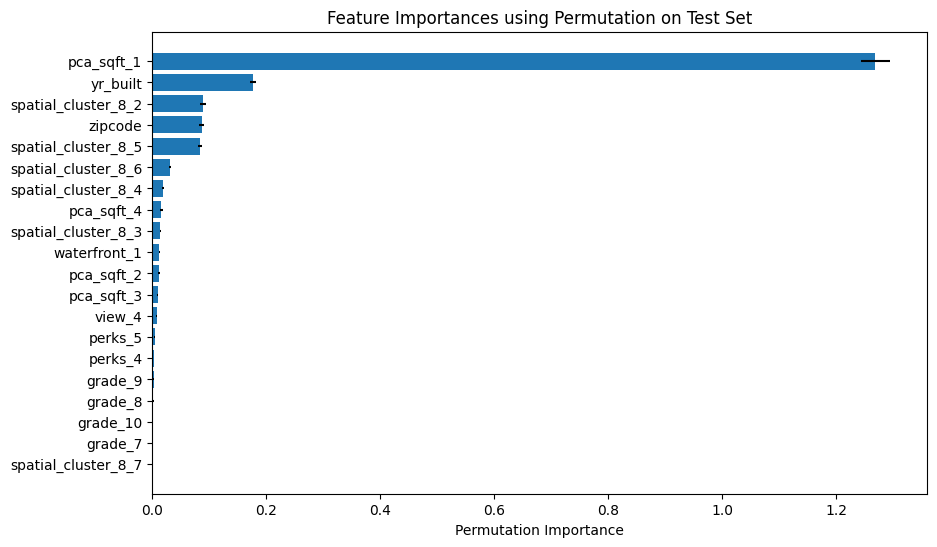

In [58]:
result = permutation_importance(
    model_1, 
    X_val, 
    y_val, 
    n_repeats=10,  # Number of times to shuffle a feature
    random_state=42, 
    n_jobs=-1      # Use all available CPU cores
)

# 2. Organize and Sort the Results
sorted_idx = result.importances_mean.argsort()
importance_df = pd.DataFrame({
    'Feature': X_val.columns[sorted_idx],
    'Importance': result.importances_mean[sorted_idx],
    'Std Dev': result.importances_std[sorted_idx]
})

# Sort descending for plotting
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Permutation Importance Results (Top 10):")
print(importance_df.head(10))

# 3. Plot the Results
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_df['Feature'][:20], importance_df['Importance'][:20], xerr=importance_df['Std Dev'][:20])
ax.set_xlabel("Permutation Importance")
ax.set_title("Feature Importances using Permutation on Test Set")
ax.invert_yaxis() # Highest importance at the top
plt.show()

In [23]:
# Panel Data Models for Causal inference
# Panel data models can be implemented using libraries like linearmodels
# Convert date column to datetime format instead of int
train_2 = df_train.copy()
train_2['date'] = pd.to_datetime(train_2['date'].astype(str))  # or use the appropriate format

# Alternatively, if your dates are in YYYYMMDD format:
# df_train['date'] = pd.to_datetime(df_train['date'].astype(str), format='%Y%m%d')

# Set the index with proper datetime format
model_2 = PanelOLS.from_formula('price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + condition + grade + sqft_above + sqft_basement + yr_built + zipcode + sqft_living15 + sqft_lot15 + EntityEffects', 
                                data=train_2.set_index(['id', 'date']), 
                                check_rank=False, drop_absorbed=True)
results_2 = model_2.fit()

ValueError: All columns in exog have been fully absorbed by the included effects. This model cannot be estimated.